# DSC 540 Advanced Machine Learning

## Machine Learning Techniques for Donor-Recipient Matching in Liver Transplantation

DePaul University   
MS Data Science  
Chien-Lin Yang  
Chicago, IL  

## Project Description

### Introduction

Donor-Recipient (D-R) matching is a challenging topic in Liver Transplantation (LT) due to the increasing number of candidates for LT and the limited number of available donors. Assigning a particular donor to potential candidates on a waiting list is controversial. Some scores have been designed to aid this process, such as the Model for End-Stage Liver Disease (MELD), which estimates a patient's chances of surviving their disease during the next three months and determines how urgently the candidate needs a transplant.The primary goal of these scores is to decrease mortality in the waiting list without affecting the result of the transplant. 

However, in some cases, a decrease in waiting list mortality leads to worse post-transplant survival results. This is because the scores prioritize urgency over other factors, such as the recipient's health status and the quality of the donor liver. D-R matching is a complex process that requires balancing multiple factors. In addition to the MELD score, other factors that should be considered include the recipient's overall health, the quality of the donor liver, and the potential risks and benefits of transplantation. Therefore, it is essential to have a comprehensive evaluation of each patient before assigning a donor liver.

In summary, while scores such as MELD can be useful in prioritizing candidates on a waiting list, they should be used in conjunction with other factors to achieve optimal D-R matching. The ultimate goal of D-R matching should be to achieve the best possible outcome for each recipient while ensuring the most efficient use of available donor livers.

The aim of this project is to simulate the data processing process and model selection of this paper [Statistical methods versus machine learning techniques for donor-recipient matching in liver transplantation](https://pubmed.ncbi.nlm.nih.gov/34019601/), to build different machine learning models, and to develop more accurate prediction models for binary classification problems with different end-points.

### Materials and methods

The data is from the United Network for Organ Sharing (UNOS) that is the mission-driven non-profit serving as the nation’s transplant system under contract with the federal government. UNOS database collects information not only from donors and recipients but also from the pre-and post-transplant from all the health care system centers of the USA.

This project would follow the criteria of the above paper to select the variables, such as recipient-related, donor-related, matching-related, and graft survival time features. Here are what the columns represent:

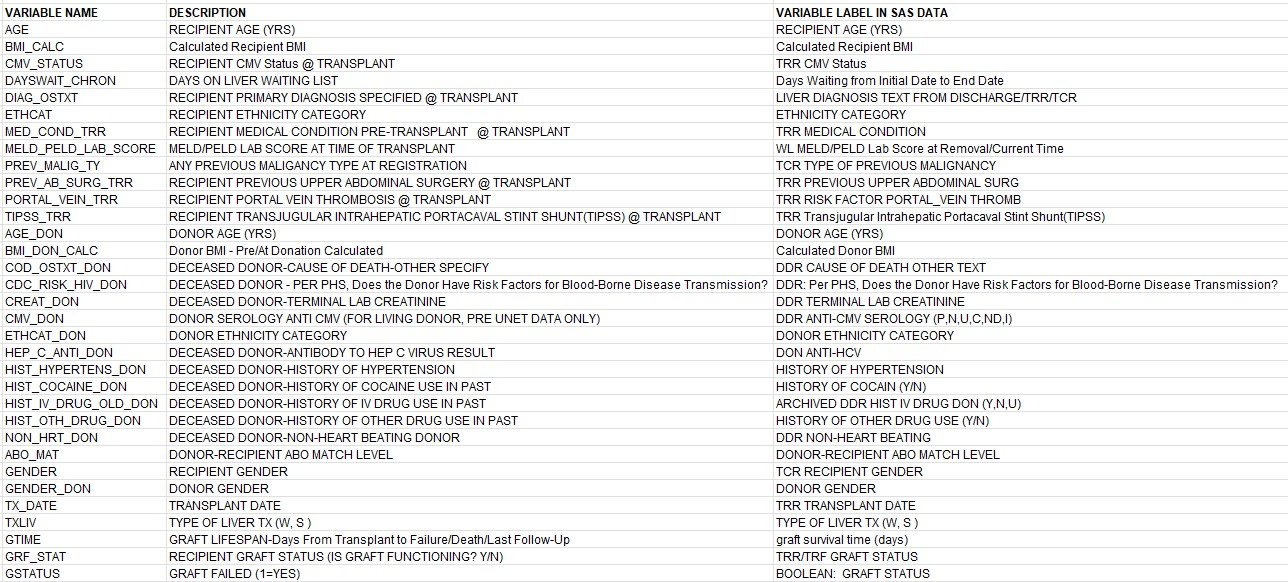

`GTIME` (graft survival time) is our independent variable. According to the paper, they have considered four different end-points (period to control graft loss): three months (3M), one year (1Y), two years (2Y), and five years (5Y). The choice of these end-points has been made by experts. Note that graft survival has been defined as the period from transplantation to the time a re-transplant is required or to the time the recipient dies.

To tackle the D-R allocation problem, I have considered different graft survival prediction methods, including Logistic Regression (LR), Decision Tree (DT), Random Forest (RF), Gradient Boosting (GB), K-Nearest Neighbours (KNN), and Support Vector Machines (SVM). Also, the hyperparameters of each technique have been chosen using another independent 10-fold cross-validation over the training set. Regarding the evaluation process, the Confusion Matrix and the Accuracy have been used.

## Import Libraries

In [3]:
from sas7bdat import SAS7BDAT
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn import metrics

In [4]:
import sklearn
sklearn.__version__

'1.0.2'

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
pd.set_option('display.max_columns', 100)
RANDOM_STATE = 0

## Data Selection

### 1. Get the data

#### Get the data from SAS Daraset

In [5]:
reader = SAS7BDAT('liver_data.sas7bdat')

In [6]:
print(reader.header)

Header:
	col_count_p1: 426
	col_count_p2: 0
	column_count: 426
	compression: SASYZCRL
	creator: None
	creator_proc: DATASTEP
	date_created: 2022-01-03 20:02:26.965000
	date_modified: 2022-01-03 20:02:26.965000
	endianess: little
	file_type: DATA
	filename: liver_data.sas7bdat
	header_length: 139264
	lcp: 8
	lcs: 0
	mix_page_row_count: 23
	name: LIVER_DATA
	os_name: 
	os_type: 
	page_count: 2586
	page_length: 139264
	platform: windows
	row_count: 332787
	row_length: 3456
	sas_release: 9.0401M6
	server_type: X64_SRV16
	u64: False

Contents of dataset "LIVER_DATA":
Num Name                            Type   Length Format   Label                                                                                        
--- ------------------------------- ------ ------ -------- ---------------------------------------------------------------------------------------------
  1 COD_WL                          number      8          WL Candidate Cause of Death for Death Removal                     

In [7]:
data = reader.to_data_frame()
data.head()

,COD_WL,COD_OSTXT_WL,NUM_PREV_TX,MELD_DIFF_REASON_CD,GENDER,ABO,WGT_KG_TCR,HGT_CM_TCR,BMI_TCR,CITIZEN_COUNTRY,EDUCATION,LIFE_SUP_TCR,VENTILATOR_TCR,OTH_LIFE_SUP_TCR,OTH_LIFE_SUP_OSTXT_TCR,FUNC_STAT_TCR,PRI_PAYMENT_TCR,DGN_TCR,DGN_OSTXT_TCR,DGN2_TCR,DGN2_OSTXT_TCR,DIAB,MALIG_TCR,HCC_DIAGNOSIS_TCR,NEOADJUVANT_THERAPY_TCR,INIT_STAT,INIT_WGT_KG,INIT_HGT_CM,REM_CD,DAYSWAIT_CHRON,END_STAT,INIT_AGE,DEATH_DATE,END_DATE,INIT_DATE,EXC_DIAG_ID,EXC_OTHER_DIAG,HCC_EVER_APPR,EXC_HCC,EXC_CASE,ETHNICITY,ETHCAT,PT_CODE,INIT_BMI_CALC,END_BMI_CALC,COMPOSITE_DEATH_DATE,WLHR,WLHL,WLIN,WLKI,...,TRR_ID_CODE,RECOV_OUT_US,RECOV_COUNTRY,CONTROLLED_DON,STATUS_DDR,VAL_DT_DDR,TATTOOS,LI_BIOPSY,PROTEIN_URINE,CARDARREST_NEURO,RESUSCIT_DUR,INOTROP_SUPPORT_DON,REFERRAL_DATE,ADMIT_DATE_DON,DONOR_ID,HBSAB_DON,EBV_IGG_CAD_DON,EBV_IGM_CAD_DON,TRANSFUS_TERM_DON,TRANSFUS_INTRAOP_NUM_OLD_DON,TRANSFUS_PRIOR_NUM_OLD_DON,CDC_RISK_HIV_DON,MACRO_FAT_LI_DON,MICRO_FAT_LI_DON,HISTORY_MI_DON,LV_EJECT_DON,LV_EJECT_METH_DON,VESSELS_NUM_STEN_DON,PH_DON,HEMATOCRIT_DON,INO_PROCURE_AGENT_1,INO_PROCURE_AGENT_2,INO_PROCURE_AGENT_3,INO_PROCURE_OSTXT_1,INO_PROCURE_OSTXT_2,INO_PROCURE_OSTXT_3,CORONARY_ANGIO_DON,CORONARY_ANGIO_NORM_DON,TX_YEAR,LIST_MELD,TX_MELD,LT_ONE_WEEK_DON,LISTYR,DATA_TRANSPLANT,DATA_WAITLIST,CTR_CODE,OPO_CTR_CODE,INIT_OPO_CTR_CODE,END_OPO_CTR_CODE,LISTING_CTR_CODE
0,NaN,,0.0,NaN,F,B,62.0,160.0,24.2187,,NaN,N,0.0,0.0,,2.0,NaN,NaN,,NaN,,NaN,,,,6040.0,62.0,160.0,4.0,12.0,6040.0,55.0,None,1994-03-10,1994-02-26,NaN,,NaN,non-HCC,No,0.0,1.0,43345.0,24.218750,24.218750,1999-06-18,,,,,...,A268583,N,,,V,1994-11-01,U,U,U,U,NaN,N,None,None,253139.0,,,,NaN,998.0,998.0,,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,N,,1994.0,Yes,Yes,N,1994.0,Y,Y,09362,19282,22537,22537,09362
1,NaN,,1.0,NaN,F,A,53.0,163.0,19.9481,,NaN,N,0.0,0.0,,2.0,NaN,NaN,,NaN,,NaN,,,,6010.0,53.0,163.0,4.0,2.0,6010.0,45.0,None,1994-03-01,1994-02-27,NaN,,NaN,non-HCC,No,0.0,1.0,345009.0,19.948060,19.948060,2017-09-04,,,,,...,A174795,N,,,V,1994-11-01,U,U,U,U,NaN,N,None,None,133931.0,,,,NaN,998.0,998.0,,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,N,,1994.0,Yes,Yes,N,1994.0,Y,Y,02666,01054,14353,14353,02666
2,NaN,,0.0,NaN,F,O,54.0,165.0,19.8347,,NaN,N,0.0,0.0,,2.0,NaN,4215.0,,NaN,,NaN,,,,6040.0,54.0,165.0,9.0,886.0,6999.0,35.0,None,1996-08-02,1994-02-28,NaN,,NaN,non-HCC,No,0.0,1.0,117434.0,19.834711,19.834711,2009-02-26,,,,,...,,,,,,NaT,,,,,NaN,,None,None,NaN,,,,NaN,NaN,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,NaN,,,,1994.0,N,Y,Unknown,Unknown,02821,02821,11129
3,NaN,,0.0,NaN,M,B,89.0,180.0,27.4691,,NaN,N,0.0,0.0,,2.0,NaN,4215.0,,NaN,,NaN,,,,6040.0,89.0,180.0,4.0,217.0,6040.0,55.0,None,1994-10-03,1994-02-28,NaN,,NaN,non-HCC,No,0.0,2.0,65262.0,27.469136,27.469136,2001-03-12,,,,,...,A236839,N,,,V,1995-01-18,U,U,U,U,NaN,N,1994-09-30,None,288454.0,,,,NaN,998.0,998.0,,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,N,,1994.0,Yes,Yes,N,1994.0,Y,Y,03503,23002,23002,23002,03503
4,NaN,,0.0,NaN,F,O,57.0,163.0,21.4536,,NaN,N,0.0,0.0,,998.0,NaN,4215.0,,NaN,,NaN,,,,6002.0,57.0,163.0,8.0,324.0,6004.0,39.0,None,1995-01-18,1994-02-28,NaN,,NaN,non-HCC,No,0.0,1.0,484619.0,21.453574,21.453574,1995-01-18,,,,,...,,,,,,NaT,,,,,NaN,,None,None,NaN,,,,NaN,NaN,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,NaN,,,,1994.0,N,Y,Unknown,Unknown,01054,01054,06107


In [8]:
data.shape

(332787, 426)

In [9]:
reader.close()

In [10]:
df = data[['AGE', 'BMI_CALC', 'CMV_STATUS', 'DAYSWAIT_CHRON', 'DIAG_OSTXT', 'ETHCAT','MED_COND_TRR', 
           'MELD_PELD_LAB_SCORE', 'PREV_MALIG_TY', 'PREV_AB_SURG_TRR', 'PORTAL_VEIN_TRR', 'TIPSS_TRR',
           
           'AGE_DON', 'BMI_DON_CALC', 'COD_OSTXT_DON', 'CDC_RISK_HIV_DON', 'CREAT_DON', 'CMV_DON', 
           'ETHCAT_DON', 'HEP_C_ANTI_DON', 'HIST_HYPERTENS_DON', 
           'HIST_COCAINE_DON', 'HIST_IV_DRUG_OLD_DON', 'HIST_OTH_DRUG_DON', 'NON_HRT_DON',
           
           'ABO_MAT', 'GENDER', 'GENDER_DON',            
        
           'TX_DATE', 'TXLIV',
           
           'GTIME','GRF_STAT', 'GSTATUS']]

In [11]:
df.shape

(332787, 33)

In [12]:
df.to_csv("liver_data_reduced.csv", encoding='utf-8', index=False)

-------------------------------------------------------------

#### Use pandas to read in the datasets as a dataframe

In [7]:
df = pd.read_csv('liver_data_reduced.csv', low_memory=False)

In [8]:
df.head()

,AGE,BMI_CALC,CMV_STATUS,DAYSWAIT_CHRON,DIAG_OSTXT,ETHCAT,MED_COND_TRR,MELD_PELD_LAB_SCORE,PREV_MALIG_TY,PREV_AB_SURG_TRR,PORTAL_VEIN_TRR,TIPSS_TRR,AGE_DON,BMI_DON_CALC,COD_OSTXT_DON,CDC_RISK_HIV_DON,CREAT_DON,CMV_DON,ETHCAT_DON,HEP_C_ANTI_DON,HIST_HYPERTENS_DON,HIST_COCAINE_DON,HIST_IV_DRUG_OLD_DON,HIST_OTH_DRUG_DON,NON_HRT_DON,ABO_MAT,GENDER,GENDER_DON,TX_DATE,TXLIV,GTIME,GRF_STAT,GSTATUS
0,55.0,24.218750,U,12.0,NaN,1.0,3.0,NaN,NaN,U,U,U,63.0,NaN,NaN,NaN,NaN,P,1.0,NaN,NaN,U,NaN,NaN,NaN,1.0,F,F,1994-03-10,W,1926.0,Y,1.0
1,45.0,19.948060,NaN,2.0,NaN,1.0,1.0,NaN,NaN,U,U,U,54.0,NaN,NaN,NaN,NaN,P,5.0,NaN,NaN,U,NaN,NaN,NaN,2.0,F,F,1994-03-01,W,8588.0,Y,1.0
2,NaN,NaN,NaN,886.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN
3,56.0,29.320988,U,217.0,NaN,2.0,3.0,NaN,NaN,N,U,U,31.0,23.082542,NaN,NaN,1.9,N,2.0,N,N,U,N,Y,N,1.0,M,M,1994-10-03,W,2352.0,Y,1.0
4,NaN,NaN,NaN,324.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332787 entries, 0 to 332786
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   AGE                   191528 non-null  float64
 1   BMI_CALC              189376 non-null  float64
 2   CMV_STATUS            179018 non-null  object 
 3   DAYSWAIT_CHRON        331606 non-null  float64
 4   DIAG_OSTXT            16518 non-null   object 
 5   ETHCAT                332787 non-null  float64
 6   MED_COND_TRR          190374 non-null  float64
 7   MELD_PELD_LAB_SCORE   138948 non-null  float64
 8   PREV_MALIG_TY         21536 non-null   float64
 9   PREV_AB_SURG_TRR      190295 non-null  object 
 10  PORTAL_VEIN_TRR       190390 non-null  object 
 11  TIPSS_TRR             190387 non-null  object 
 12  AGE_DON               191476 non-null  float64
 13  BMI_DON_CALC          179111 non-null  float64
 14  COD_OSTXT_DON         9803 non-null    object 
 15  

In [10]:
df.shape

(332787, 33)

### 2. Patient selection and exclusion criteria

#### a. Remove non-transplanted and failed samples

In [11]:
df = df.dropna(subset=['TX_DATE', 'GTIME', 'GRF_STAT', 'GSTATUS', 'GSTATUS'])

In [12]:
df = df[df['GRF_STAT']=='Y']
df = df[df['GSTATUS']==0]

In [13]:
df.shape

(95599, 33)

#### b. Select transplants performed from November 2004 onwards

Although it was founded in March 1984, we have considered those transplants performed from November 2004 onwards, date when the last change of variable formats was made.

In [14]:
df['TX_DATE'] = pd.to_datetime(df['TX_DATE'])

In [15]:
mask = (df['TX_DATE'] >= '2004-11-1') 
df=df.loc[mask]

In [16]:
df.TX_DATE.min()

Timestamp('2004-11-01 00:00:00')

In [17]:
df.shape

(82362, 33)

#### c. Partial and split liver transplants are excluded from the study.

In [18]:
df['TXLIV'].value_counts() #TYPE OF LIVER TX (W-Whole, S-Segment/Split)

W    76215
S     6147
Name: TXLIV, dtype: int64

In [19]:
df = df[df['TXLIV']!='S']

In [20]:
df.shape

(76215, 33)

#### d. All the recipients older than 18 years are included.

In [21]:
df = df[df['AGE']>=18]

In [22]:
df.shape

(70961, 33)

#### e. Remove variables not from the paper

In [23]:
df = df.drop(columns=['TX_DATE','TXLIV', 'GRF_STAT', 'GSTATUS'])

In [24]:
df.shape

(70961, 29)

## Data Exploration

In [25]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AGE,70961.0,NaN,NaN,NaN,54.611477,10.895478,18.0,49.0,56.0,62.0,81.0
BMI_CALC,70940.0,NaN,NaN,NaN,28.667284,5.849439,15.015611,24.41213,27.976818,32.246375,69.721077
CMV_STATUS,70649,4,P,44421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYSWAIT_CHRON,70961.0,NaN,NaN,NaN,239.723764,470.037226,0.0,13.0,77.0,268.0,10355.0
DIAG_OSTXT,4481,2296,AUTOIMMUNE HEPATITIS,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ETHCAT,70961.0,NaN,NaN,NaN,1.808853,1.465159,1.0,1.0,1.0,2.0,9.0
MED_COND_TRR,70954.0,NaN,NaN,NaN,2.519548,0.726774,1.0,2.0,3.0,3.0,3.0
MELD_PELD_LAB_SCORE,70950.0,NaN,NaN,NaN,23.327526,10.753029,6.0,15.0,22.0,31.0,76.0
PREV_MALIG_TY,12251.0,NaN,NaN,NaN,2889.63856,2448.45033,1.0,1024.0,4096.0,4096.0,20480.0
PREV_AB_SURG_TRR,70954,3,N,36865,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Create a correlation map between the variables.

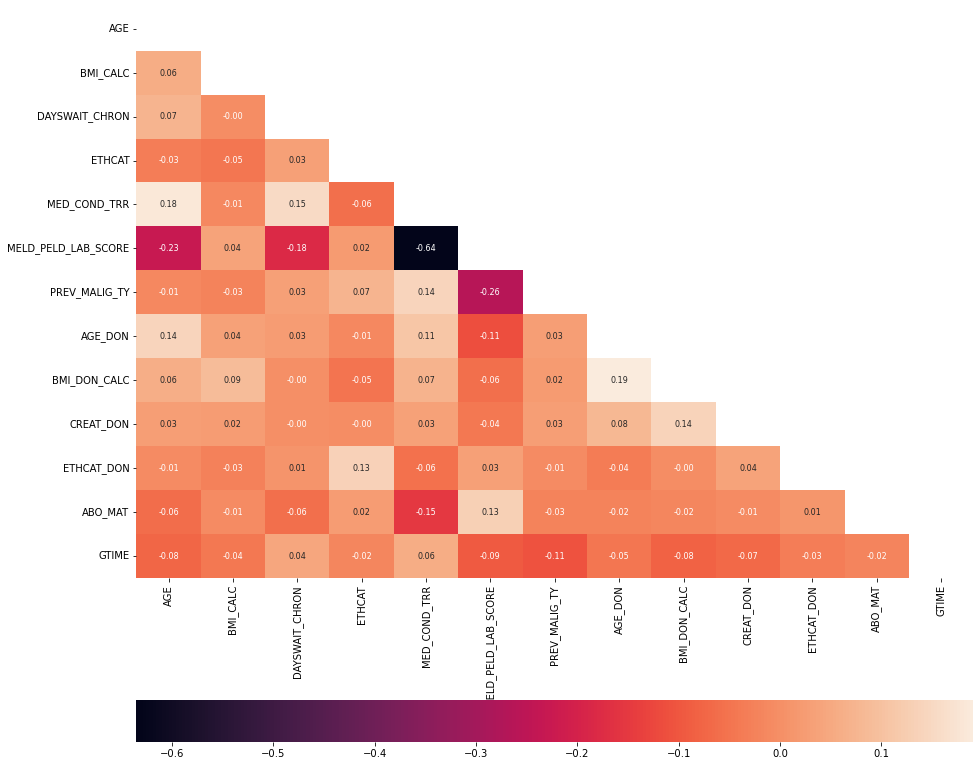

In [26]:
mask = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), mask=mask, annot=True, annot_kws={'size':8}, fmt = '.2f', cbar_kws = {'orientation':'horizontal'})
plt.show()

`MELD_PELD_LAB_SCORE` and `MED_COND_TRR` have higher correlation than the others.
- `MELD_PELD_LAB_SCORE`:MELD/PELD Score
- `MED_COND_TRR`: Medical condition

#### Create a histogram

<AxesSubplot:xlabel='MELD_PELD_LAB_SCORE', ylabel='Count'>

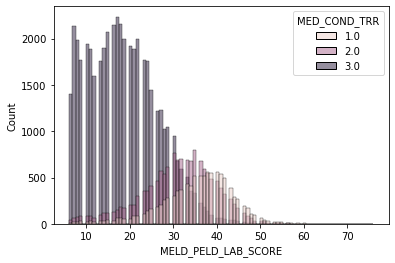

In [27]:
sns.histplot(data=df, x='MELD_PELD_LAB_SCORE', hue='MED_COND_TRR')

#### Create jointplots

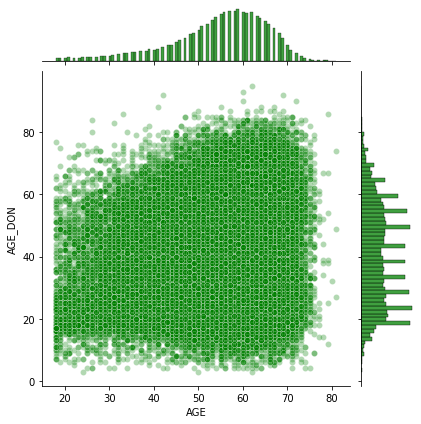

In [28]:
# Recipient Age (AGE) vs. Donor Age (AGE_DON)
sns.jointplot(data=df, x='AGE', y='AGE_DON', color='g', alpha=0.3)
plt.show()

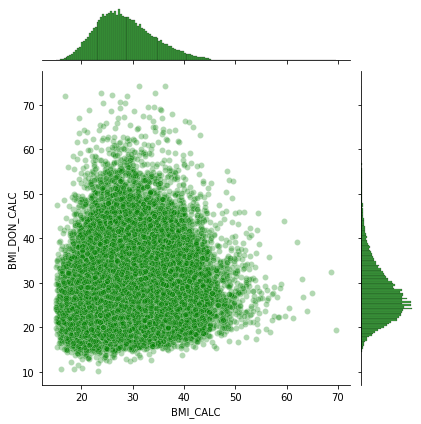

In [29]:
# Recipient BMI (BMI_CALC) vs. Donor BMI (BMI_DON_CALC)
sns.jointplot(data=df, x='BMI_CALC', y='BMI_DON_CALC', color='g', alpha=0.3)
plt.show()

#### Create scatter plots

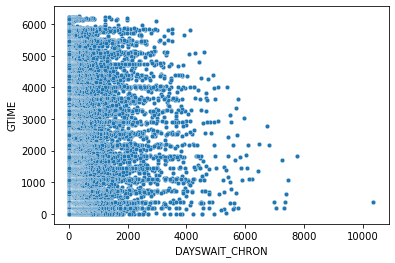

In [30]:
# Days Waiting from Initial Date to End Date (DAYSWAIT_CHRON) vs. Graft Survival Time (days) (GTIME)
df.plot(x = 'DAYSWAIT_CHRON', y = 'GTIME', kind = 'scatter', edgecolors = 'w', linewidths = 0.3)
plt.xlabel('DAYSWAIT_CHRON')
plt.ylabel('GTIME')
plt.show()

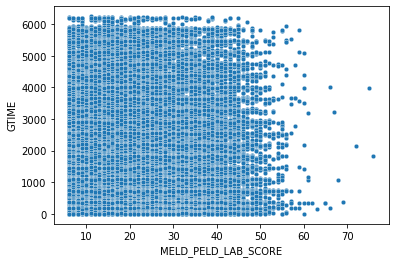

In [31]:
# MELD_PELD_LAB_SCORE (MELD/PELD Score) vs. Graft Survival Time (days) (GTIME)
df.plot(x = 'MELD_PELD_LAB_SCORE', y = 'GTIME', kind = 'scatter', edgecolors = 'w', linewidths = 0.3)
plt.xlabel('MELD_PELD_LAB_SCORE')
plt.ylabel('GTIME')
plt.show()

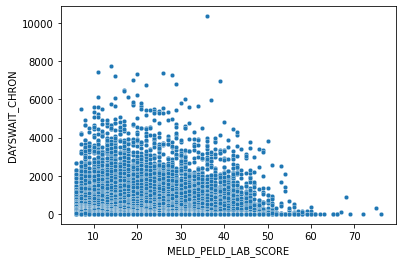

In [32]:
# MELD_PELD_LAB_SCORE (MELD/PELD Score) vs. Days Waiting from Initial Date to End Date (DAYSWAIT_CHRON
df.plot(x = 'MELD_PELD_LAB_SCORE', y = 'DAYSWAIT_CHRON', kind = 'scatter', edgecolors = 'w', linewidths = 0.3)
plt.xlabel('MELD_PELD_LAB_SCORE')
plt.ylabel('DAYSWAIT_CHRON')
plt.show()

#### Create histograms

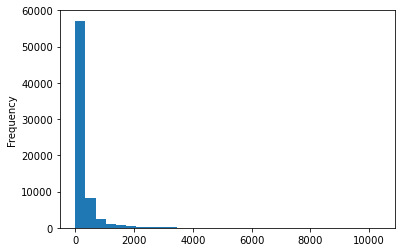

In [33]:
# Days Waiting from Initial Date to End Date (DAYSWAIT_CHRON)
df['DAYSWAIT_CHRON'].plot(kind = 'hist',bins = 30)
plt.show()

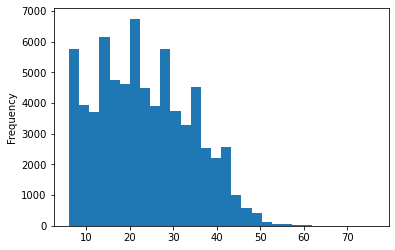

In [34]:
# MELD_PELD_LAB_SCORE (MELD/PELD Score)
df['MELD_PELD_LAB_SCORE'].plot(kind = 'hist',bins = 30)
plt.show()

#### Create a countplot

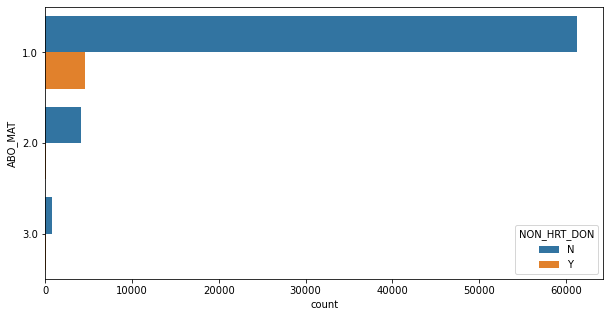

In [35]:
# Donor-Recipient ABO match level (ABO_MAT) vs. Deceased Donor-Non-Heart beating donor (NON_HRT_DON)
plt.subplots(figsize=(10,5))
sns.countplot(y=df['ABO_MAT'], hue=df['NON_HRT_DON'])
plt.show()

## Data Cleaning

### 1. Dealing with Missing Value and Categorical variables

- In Numeric variables: Replace missing values with mean.
- In Categorical variables: Remove missing value and unknown value.

In [36]:
df.shape

(70961, 29)

In [37]:
df.isnull().sum()

AGE                         0
BMI_CALC                   21
CMV_STATUS                312
DAYSWAIT_CHRON              0
DIAG_OSTXT              66480
ETHCAT                      0
MED_COND_TRR                7
MELD_PELD_LAB_SCORE        11
PREV_MALIG_TY           58710
PREV_AB_SURG_TRR            7
PORTAL_VEIN_TRR             8
TIPSS_TRR                   8
AGE_DON                     4
BMI_DON_CALC               97
COD_OSTXT_DON           69490
CDC_RISK_HIV_DON           78
CREAT_DON                 120
CMV_DON                    78
ETHCAT_DON                  0
HEP_C_ANTI_DON             78
HIST_HYPERTENS_DON         78
HIST_COCAINE_DON          114
HIST_IV_DRUG_OLD_DON    70961
HIST_OTH_DRUG_DON         114
NON_HRT_DON                78
ABO_MAT                     0
GENDER                      0
GENDER_DON                  0
GTIME                       0
dtype: int64

####  Numeric variables

In [38]:
df.AGE_DON.fillna(df.AGE_DON.mean(), inplace=True)

In [39]:
df.BMI_CALC.fillna(df.BMI_CALC.mean(), inplace=True)

In [40]:
df.BMI_DON_CALC.fillna(df.BMI_DON_CALC.mean(), inplace=True)

In [41]:
df.MELD_PELD_LAB_SCORE.fillna(df.MELD_PELD_LAB_SCORE.mean(), inplace=True)

In [42]:
df.CREAT_DON.fillna(df.CREAT_DON.mean(), inplace=True)

#### Categorical variables

In [43]:
df = df[df['CMV_STATUS'].isin(['P', 'N'])]
df['CMV_STATUS'] = np.where(df.CMV_STATUS=='P', 1, 0) # 0:absense/negative; 1:presence/positive

In [44]:
df = df[df['CMV_DON'].isin(['P', 'N'])]
df['CMV_DON'] = np.where(df.CMV_DON=='P', 1, 0) # 0:absense/negative; 1:presence/positive

- For `DIAG_OSTXT`, choose top 5 reasons

In [45]:
def label1(df):
    if df['DIAG_OSTXT'] == 'AUTOIMMUNE HEPATITIS':
        return 0
    elif df['DIAG_OSTXT'] == 'HEPATIC ARTERY THROMBOSIS':
        return 1
    elif df['DIAG_OSTXT'] == 'SARCOIDOSIS':
        return 2
    elif df['DIAG_OSTXT'] == 'TYLENOL':
        return 3
    elif df['DIAG_OSTXT'] == 'FULMINANT':
        return 4
    else:
        return 5 
    
df['DIAG_OSTXT'] = df.apply(label1, axis=1)

In [46]:
df = df.dropna(subset=['MED_COND_TRR'])

In [47]:
df['PREV_MALIG_TY'] = np.where(df.PREV_MALIG_TY.isnull(), 0, 1) # 0:absense; 1:presence

In [48]:
df = df[df['PREV_AB_SURG_TRR'].isin(['Y', 'N'])]
df['PREV_AB_SURG_TRR'] = np.where(df.PREV_AB_SURG_TRR=='Y', 1, 0) # 0:absense; 1:presence

In [49]:
df = df[df['PORTAL_VEIN_TRR'].isin(['Y', 'N'])]
df['PORTAL_VEIN_TRR'] = np.where(df.PORTAL_VEIN_TRR=='Y', 1, 0) # 0:absense; 1:presence

In [50]:
df = df[df['TIPSS_TRR'].isin(['Y', 'N'])]
df['TIPSS_TRR'] = np.where(df.TIPSS_TRR=='Y', 1, 0) # 0:absense; 1:presence

- For `COD_OSTXT_DON`, choose top 4 reasons

In [51]:
def label2(df):
    if df['COD_OSTXT_DON'] == 'OVERDOSE':
        return 0
    elif df['COD_OSTXT_DON'] == 'CARDIAC - OTHER, SPECIFY':
        return 1
    elif df['COD_OSTXT_DON'] == 'TRAUMA':
        return 2
    elif df['COD_OSTXT_DON'] == 'INFECTIOUS DISEASE - BACTERIAL':
        return 3
    else:
        return 4 
    
df['COD_OSTXT_DON'] = df.apply(label2, axis=1)

In [52]:
df = df[df['CDC_RISK_HIV_DON'].isin(['Y', 'N'])]
df['CDC_RISK_HIV_DON'] = np.where(df.CDC_RISK_HIV_DON=='Y', 1, 0) # 0:absense; 1:presence

In [53]:
df = df[df['HEP_C_ANTI_DON'].isin(['P', 'N'])]
df['HEP_C_ANTI_DON'] = np.where(df.HEP_C_ANTI_DON=='P', 1, 0) # 0:absense; 1:presence

In [54]:
df = df[df['HIST_HYPERTENS_DON'].isin(['Y', 'N'])]
df['HIST_HYPERTENS_DON'] = np.where(df.HIST_HYPERTENS_DON=='Y', 1, 0) # 0:absense; 1:presence

- We only need to know if there is a History of Drugs, so I combine the three variables into a new variable, called `HIST_DRUG_DON`.

In [55]:
df['HIST_COCAINE_DON'] = np.where(df.HIST_COCAINE_DON=='Y', 1, 0) # 0:absense; 1:presence
df['HIST_IV_DRUG_OLD_DON'] = np.where(df.HIST_IV_DRUG_OLD_DON=='Y', 1, 0) # 0:absense; 1:presence
df['HIST_OTH_DRUG_DON'] = np.where(df.HIST_OTH_DRUG_DON=='Y', 1, 0) # 0:absense; 1:presence

df['HIST_DRUG_DON'] = df['HIST_COCAINE_DON'] + df['HIST_IV_DRUG_OLD_DON'] + df['HIST_OTH_DRUG_DON'] #combine 3 variables
df['HIST_DRUG_DON'] = np.where(df.HIST_DRUG_DON==0, 0, 1) # 0:absense; 1:presence (sum =0 ->0, the others ->1)

df = df.drop(columns=['HIST_COCAINE_DON', 'HIST_IV_DRUG_OLD_DON', 'HIST_OTH_DRUG_DON'])

In [56]:
df['NON_HRT_DON'] = np.where(df.NON_HRT_DON=='Y', 1, 0) # 0:absense; 1:presence

`ABO_MAT`Donor–recipient ABO matching was categorized as 
- 1 = ABO identical (recipient received a liver with the exact same ABO blood type) 
- 2 = ABO compatible (a blood type A, B or AB recipient received a liver from blood type O donor or a blood type AB recipient received a liver from a blood type O, A or B donor)
- 3 = ABO incompatible (all other combinations).

In [57]:
df['ABO_MAT'] = np.where(df.ABO_MAT==3, 0, 1) # 0:non-compatible; 1:compatible

In [58]:
# Gender Compatibility
# 0: Same gender; 1: Donor male and Recipient female; 2: Donor female and Recipient male
def label3(df):
    if df['GENDER'] == df['GENDER_DON']:
        return 0
    elif df['GENDER'] == 'F' and df['GENDER_DON'] == 'M':
        return 1
    else:
        return 2
df['GENDER_COM'] = df.apply(label3, axis=1)
df = df.drop(columns=['GENDER', 'GENDER_DON'])

In [59]:
df.isnull().sum()

AGE                    0
BMI_CALC               0
CMV_STATUS             0
DAYSWAIT_CHRON         0
DIAG_OSTXT             0
ETHCAT                 0
MED_COND_TRR           0
MELD_PELD_LAB_SCORE    0
PREV_MALIG_TY          0
PREV_AB_SURG_TRR       0
PORTAL_VEIN_TRR        0
TIPSS_TRR              0
AGE_DON                0
BMI_DON_CALC           0
COD_OSTXT_DON          0
CDC_RISK_HIV_DON       0
CREAT_DON              0
CMV_DON                0
ETHCAT_DON             0
HEP_C_ANTI_DON         0
HIST_HYPERTENS_DON     0
NON_HRT_DON            0
ABO_MAT                0
GTIME                  0
HIST_DRUG_DON          0
GENDER_COM             0
dtype: int64

In [60]:
df.shape

(65723, 26)

### 2. Check Dtype

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65723 entries, 58536 to 332248
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  65723 non-null  float64
 1   BMI_CALC             65723 non-null  float64
 2   CMV_STATUS           65723 non-null  int32  
 3   DAYSWAIT_CHRON       65723 non-null  float64
 4   DIAG_OSTXT           65723 non-null  int64  
 5   ETHCAT               65723 non-null  float64
 6   MED_COND_TRR         65723 non-null  float64
 7   MELD_PELD_LAB_SCORE  65723 non-null  float64
 8   PREV_MALIG_TY        65723 non-null  int32  
 9   PREV_AB_SURG_TRR     65723 non-null  int32  
 10  PORTAL_VEIN_TRR      65723 non-null  int32  
 11  TIPSS_TRR            65723 non-null  int32  
 12  AGE_DON              65723 non-null  float64
 13  BMI_DON_CALC         65723 non-null  float64
 14  COD_OSTXT_DON        65723 non-null  int64  
 15  CDC_RISK_HIV_DON     65723 non-

In [62]:
df[['AGE','DAYSWAIT_CHRON', 
    'MELD_PELD_LAB_SCORE', 'AGE_DON', 'GTIME']] = df[['AGE','DAYSWAIT_CHRON', 
                                                      'MELD_PELD_LAB_SCORE', 'AGE_DON', 'GTIME']].astype('int64')

In [63]:
df[['CMV_STATUS', 'DIAG_OSTXT', 'ETHCAT', 
    'MED_COND_TRR', 'PREV_MALIG_TY', 'PREV_AB_SURG_TRR', 
    'PORTAL_VEIN_TRR', 'TIPSS_TRR', 'COD_OSTXT_DON', 
    'CDC_RISK_HIV_DON', 'CMV_DON', 'ETHCAT_DON', 
    'HEP_C_ANTI_DON', 'HIST_HYPERTENS_DON', 'NON_HRT_DON', 
    'ABO_MAT', 'HIST_DRUG_DON', 'GENDER_COM']] = df[['CMV_STATUS', 'DIAG_OSTXT', 'ETHCAT', 
                                                     'MED_COND_TRR', 'PREV_MALIG_TY', 'PREV_AB_SURG_TRR', 
                                                     'PORTAL_VEIN_TRR', 'TIPSS_TRR', 'COD_OSTXT_DON', 
                                                     'CDC_RISK_HIV_DON', 'CMV_DON', 'ETHCAT_DON', 
                                                     'HEP_C_ANTI_DON', 'HIST_HYPERTENS_DON', 'NON_HRT_DON', 
                                                     'ABO_MAT', 'HIST_DRUG_DON', 'GENDER_COM']].astype('category')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65723 entries, 58536 to 332248
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   AGE                  65723 non-null  int64   
 1   BMI_CALC             65723 non-null  float64 
 2   CMV_STATUS           65723 non-null  category
 3   DAYSWAIT_CHRON       65723 non-null  int64   
 4   DIAG_OSTXT           65723 non-null  category
 5   ETHCAT               65723 non-null  category
 6   MED_COND_TRR         65723 non-null  category
 7   MELD_PELD_LAB_SCORE  65723 non-null  int64   
 8   PREV_MALIG_TY        65723 non-null  category
 9   PREV_AB_SURG_TRR     65723 non-null  category
 10  PORTAL_VEIN_TRR      65723 non-null  category
 11  TIPSS_TRR            65723 non-null  category
 12  AGE_DON              65723 non-null  int64   
 13  BMI_DON_CALC         65723 non-null  float64 
 14  COD_OSTXT_DON        65723 non-null  category
 15  CDC_RISK_HIV_D

Now, we have 65,723 samples and 26 variables, including 18 categorical variables and 8 numerical variables.

## Data Preprocessing

### 1. Making Dummy Variables

In [65]:
cat_feats = ['CMV_STATUS', 'DIAG_OSTXT', 'ETHCAT', 'MED_COND_TRR', 'PREV_MALIG_TY', 'PREV_AB_SURG_TRR', 
             'PORTAL_VEIN_TRR', 'TIPSS_TRR', 'COD_OSTXT_DON', 'CDC_RISK_HIV_DON', 'CMV_DON', 'ETHCAT_DON', 
             'HEP_C_ANTI_DON', 'HIST_HYPERTENS_DON', 'NON_HRT_DON', 'ABO_MAT', 'HIST_DRUG_DON', 'GENDER_COM']

In [66]:
df = pd.get_dummies(df, columns=cat_feats, drop_first=False)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65723 entries, 58536 to 332248
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AGE                   65723 non-null  int64  
 1   BMI_CALC              65723 non-null  float64
 2   DAYSWAIT_CHRON        65723 non-null  int64  
 3   MELD_PELD_LAB_SCORE   65723 non-null  int64  
 4   AGE_DON               65723 non-null  int64  
 5   BMI_DON_CALC          65723 non-null  float64
 6   CREAT_DON             65723 non-null  float64
 7   GTIME                 65723 non-null  int64  
 8   CMV_STATUS_0          65723 non-null  uint8  
 9   CMV_STATUS_1          65723 non-null  uint8  
 10  DIAG_OSTXT_0          65723 non-null  uint8  
 11  DIAG_OSTXT_1          65723 non-null  uint8  
 12  DIAG_OSTXT_2          65723 non-null  uint8  
 13  DIAG_OSTXT_3          65723 non-null  uint8  
 14  DIAG_OSTXT_4          65723 non-null  uint8  
 15  DIAG_OSTXT_5  

In [68]:
df.head()

,AGE,BMI_CALC,DAYSWAIT_CHRON,MELD_PELD_LAB_SCORE,AGE_DON,BMI_DON_CALC,CREAT_DON,GTIME,CMV_STATUS_0,CMV_STATUS_1,DIAG_OSTXT_0,DIAG_OSTXT_1,DIAG_OSTXT_2,DIAG_OSTXT_3,DIAG_OSTXT_4,DIAG_OSTXT_5,ETHCAT_1.0,ETHCAT_2.0,ETHCAT_4.0,ETHCAT_5.0,ETHCAT_6.0,ETHCAT_7.0,ETHCAT_9.0,MED_COND_TRR_1.0,MED_COND_TRR_2.0,MED_COND_TRR_3.0,PREV_MALIG_TY_0,PREV_MALIG_TY_1,PREV_AB_SURG_TRR_0,PREV_AB_SURG_TRR_1,PORTAL_VEIN_TRR_0,PORTAL_VEIN_TRR_1,TIPSS_TRR_0,TIPSS_TRR_1,COD_OSTXT_DON_0,COD_OSTXT_DON_1,COD_OSTXT_DON_2,COD_OSTXT_DON_3,COD_OSTXT_DON_4,CDC_RISK_HIV_DON_0,CDC_RISK_HIV_DON_1,CMV_DON_0,CMV_DON_1,ETHCAT_DON_1.0,ETHCAT_DON_2.0,ETHCAT_DON_4.0,ETHCAT_DON_5.0,ETHCAT_DON_6.0,ETHCAT_DON_7.0,ETHCAT_DON_9.0,HEP_C_ANTI_DON_0,HEP_C_ANTI_DON_1,HIST_HYPERTENS_DON_0,HIST_HYPERTENS_DON_1,NON_HRT_DON_0,NON_HRT_DON_1,ABO_MAT_0,ABO_MAT_1,HIST_DRUG_DON_0,HIST_DRUG_DON_1,GENDER_COM_0,GENDER_COM_1,GENDER_COM_2
58536,63,24.127206,10355,36,36,24.234694,2.22,388,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1
58911,46,22.705124,4124,29,58,21.561091,0.70,5812,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0
58973,67,25.802002,4610,31,23,33.386148,1.90,5106,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,0
59081,34,27.672718,6734,22,54,37.653061,0.50,2792,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,1
59445,57,24.837540,5743,19,47,22.994615,8.80,3648,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0


In [69]:
df.shape

(65723, 63)

After making dummy variables, our number of variables become from 26 to 63. 

### 2. Binning and/or Smoothing

`GTIME`(graft survival time) is the independent variable. I split it to 4 end-points:three months (3M), one year (1Y), two years (2Y) and five years (5Y), and in each end-pint there are 0(Non-Survival) and 1(Survival).

For example, `y_3M` means that if the graft survival time of the sample is over 3 months, the graft remains successful, and that sample as 1 in the `y_3M` label. Therefore, as time increases, the sample of graft survival decreases, so the graft survival class 1 is lower than non-survival class 0 in `y_5Y`.

In [70]:
from sklearn.preprocessing import FunctionTransformer

In [71]:
X = df.drop('GTIME',axis=1)
y = df.GTIME

In [72]:
y.max()

6235

<AxesSubplot:>

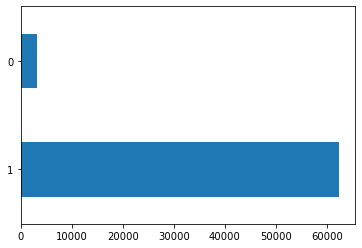

In [73]:
y_3M = np.where(y>=90, 1, 0) # 0:Non-Survival; 1:Survival over 3M
y_3M = pd.Series(y_3M)
y_3M.value_counts().plot.barh()

<AxesSubplot:>

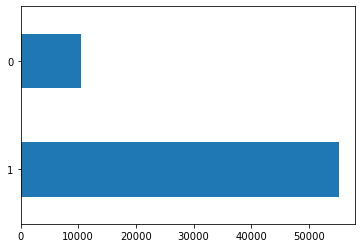

In [74]:
y_1Y = np.where(y>=365, 1, 0) # 0:Non-Survival; 1:Survival over 1Y
y_1Y = pd.Series(y_1Y)
y_1Y.value_counts().plot.barh()

<AxesSubplot:>

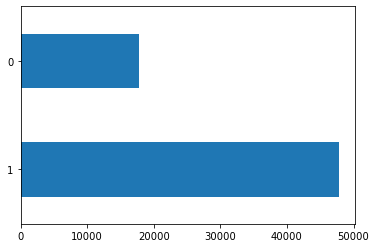

In [75]:
y_2Y = np.where(y>=730, 1, 0) # 0:Non-Survival; 1:Survival over 2Y
y_2Y = pd.Series(y_2Y)
y_2Y.value_counts().plot.barh()

<AxesSubplot:>

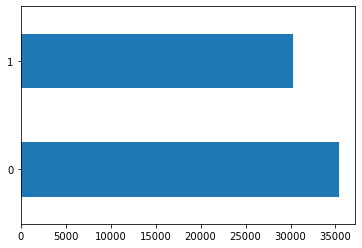

In [76]:
y_5Y = np.where(y>=1825, 1, 0) # 0:Non-Survival; 1:Survival over 5Y
y_5Y = pd.Series(y_5Y)
y_5Y.value_counts().plot.barh()

### 3. Train Test Split

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train3M, X_test3M, y_train3M, y_test3M = train_test_split(X, y_3M, test_size=0.40, random_state=RANDOM_STATE)
X_val3M, X_test3M, y_val3M, y_test3M = train_test_split(X_test3M, y_test3M, test_size=0.50, random_state=RANDOM_STATE)

In [79]:
X_train1Y, X_test1Y, y_train1Y, y_test1Y = train_test_split(X, y_1Y, test_size=0.40, random_state=RANDOM_STATE)
X_val1Y, X_test1Y, y_val1Y, y_test1Y = train_test_split(X_test1Y, y_test1Y, test_size=0.50, random_state=RANDOM_STATE)

In [80]:
X_train2Y, X_test2Y, y_train2Y, y_test2Y = train_test_split(X, y_2Y, test_size=0.40, random_state=RANDOM_STATE)
X_val2Y, X_test2Y, y_val2Y, y_test2Y = train_test_split(X_test2Y, y_test2Y, test_size=0.50, random_state=RANDOM_STATE)

In [81]:
X_train5Y, X_test5Y, y_train5Y, y_test5Y = train_test_split(X, y_5Y, test_size=0.40, random_state=RANDOM_STATE)
X_val5Y, X_test5Y, y_val5Y, y_test5Y = train_test_split(X_test5Y, y_test5Y, test_size=0.50, random_state=RANDOM_STATE)

## Classification

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [83]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cv

StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

### 1. Logistic Regression (LR) 

- Logistic regression with 10 cross validation
- Using the training data perform hyper-parameter tuning. 
- Use an appropriate metric for scoring (Recall). The best parameter configuration is the one that obtained the maximum Recall in the nested 10-fold cross-validation because one of the main objectives is to increase the classification rate of the minority class (in this case, the non-survival).
- Perform grid search (`GridSearchCV`) where checking for the following parameters.
- Using the best model provide the performance metrics for the validation set.
- Hyperparameters used during the model selection:

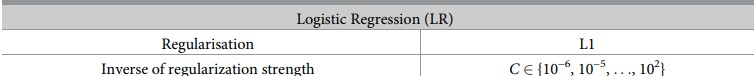

In [90]:
from sklearn.linear_model import LogisticRegression

In [91]:
params = dict(
    penalty = ['l1'],
    solver= ['liblinear'],
    C = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2]
)

params

{'penalty': ['l1'],
 'solver': ['liblinear'],
 'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [92]:
lr = LogisticRegression()
gs_lr = GridSearchCV(estimator=lr, param_grid=params, scoring='recall', cv=cv, n_jobs=-1)

#### 1-a. 3 months end-point

In [93]:
%%time
gs_lr.fit(X_train3M, y_train3M)

CPU times: total: 1.3 s
Wall time: 27.7 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100],
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='recall')

In [94]:
gs_lr.best_estimator_.get_params()

{'C': 1e-05,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [95]:
best_estimator_lr3M = gs_lr.best_estimator_

LR-3M Validation Score: 0.9493
------------------------------------------------------------


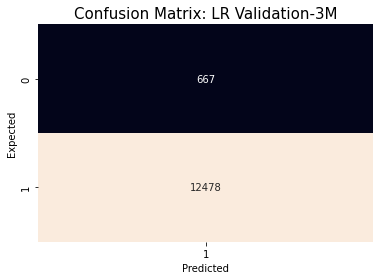

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       667
           1       0.95      1.00      0.97     12478

    accuracy                           0.95     13145
   macro avg       0.47      0.50      0.49     13145
weighted avg       0.90      0.95      0.92     13145



In [96]:
pred_val3M = best_estimator_lr3M.predict(X_val3M)
print('LR-3M Validation Score: %.4f' % metrics.accuracy_score(y_val3M, pred_val3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val3M, columns=pred_val3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: LR Validation-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val3M, pred_val3M))

#### 1-b. 1 year end-point

In [97]:
%%time
gs_lr.fit(X_train1Y, y_train1Y)

CPU times: total: 938 ms
Wall time: 20.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100],
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='recall')

In [98]:
gs_lr.best_estimator_.get_params()

{'C': 1e-05,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [99]:
best_estimator_lr1Y = gs_lr.best_estimator_

LR-1Y Validation Score: 0.8392
------------------------------------------------------------


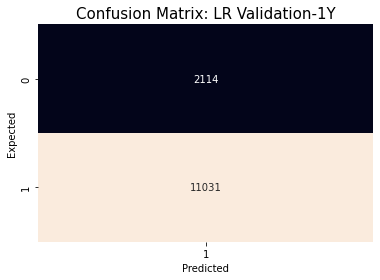

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2114
           1       0.84      1.00      0.91     11031

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.70      0.84      0.77     13145



In [100]:
pred_val1Y = best_estimator_lr1Y.predict(X_val1Y)
print('LR-1Y Validation Score: %.4f' % metrics.accuracy_score(y_val1Y, pred_val1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val1Y, columns=pred_val1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: LR Validation-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val1Y, pred_val1Y))

#### 1-c. 2 years end-point

In [101]:
%%time
gs_lr.fit(X_train2Y, y_train2Y)

CPU times: total: 1.23 s
Wall time: 21 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100],
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='recall')

In [102]:
gs_lr.best_estimator_.get_params()

{'C': 1e-05,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [103]:
best_estimator_lr2Y = gs_lr.best_estimator_

LR-2Y Validation Score: 0.7262
------------------------------------------------------------


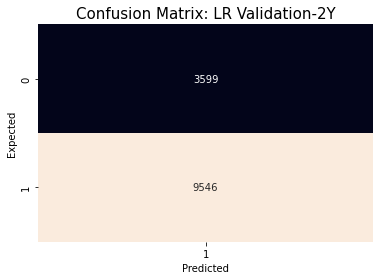

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3599
           1       0.73      1.00      0.84      9546

    accuracy                           0.73     13145
   macro avg       0.36      0.50      0.42     13145
weighted avg       0.53      0.73      0.61     13145



In [104]:
pred_val2Y = best_estimator_lr2Y.predict(X_val2Y)
print('LR-2Y Validation Score: %.4f' % metrics.accuracy_score(y_val2Y, pred_val2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val2Y, columns=pred_val2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: LR Validation-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val2Y, pred_val2Y))

#### 1-d. 5 years end-point

In [105]:
%%time
gs_lr.fit(X_train5Y, y_train5Y)

CPU times: total: 2.72 s
Wall time: 1min 12s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100],
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='recall')

In [106]:
gs_lr.best_estimator_.get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [107]:
best_estimator_lr5Y = gs_lr.best_estimator_

LR-5Y Validation Score: 0.6234
------------------------------------------------------------


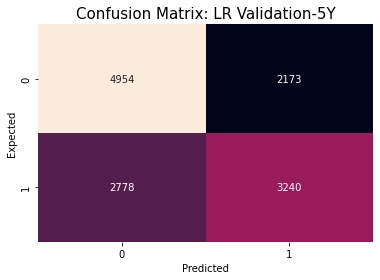

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      7127
           1       0.60      0.54      0.57      6018

    accuracy                           0.62     13145
   macro avg       0.62      0.62      0.62     13145
weighted avg       0.62      0.62      0.62     13145



In [108]:
pred_val5Y = best_estimator_lr5Y.predict(X_val5Y)
print('LR-5Y Validation Score: %.4f' % metrics.accuracy_score(y_val5Y, pred_val5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val5Y, columns=pred_val5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: LR Validation-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val5Y, pred_val5Y))

### 2. Decision Tree (DT) 

- Decision Tree with 10 cross validation
- Using the training data perform hyper-parameter tuning. 
- Use an appropriate metric for scoring (Recall). The best parameter configuration is the one that obtained the maximum Recall in the nested 10-fold cross-validation because one of the main objectives is to increase the classification rate of the minority class (in this case, the non-survival).
- Perform grid search (`GridSearchCV`) where checking for the following parameters.
- Using the best model provide the performance metrics for the validation set.
- Hyperparameters used during the model selection:

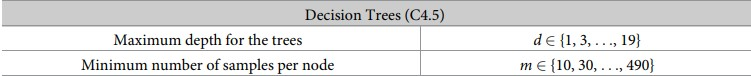

In [112]:
from sklearn.tree import DecisionTreeClassifier

In [113]:
# Create parameters dictionary
params = dict(
    max_depth = [i for i in range(1,20,2)],
    min_samples_leaf = [i for i in range(10,500,20)]
)

params

{'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'min_samples_leaf': [10,
  30,
  50,
  70,
  90,
  110,
  130,
  150,
  170,
  190,
  210,
  230,
  250,
  270,
  290,
  310,
  330,
  350,
  370,
  390,
  410,
  430,
  450,
  470,
  490]}

In [114]:
dt = DecisionTreeClassifier()
gs_dt = GridSearchCV(estimator=dt, param_grid=params, scoring='recall', cv=cv, n_jobs=-1)

#### 2-a. 3 months end-point

In [115]:
%%time
gs_dt.fit(X_train3M, y_train3M)

CPU times: total: 27.2 s
Wall time: 3min 17s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_leaf': [10, 30, 50, 70, 90, 110, 130, 150,
                                              170, 190, 210, 230, 250, 270, 290,
                                              310, 330, 350, 370, 390, 410, 430,
                                              450, 470, 490]},
             scoring='recall')

In [116]:
gs_dt.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [117]:
best_estimator_dt3M = gs_dt.best_estimator_

DT-3M Validation Score: 0.9493
------------------------------------------------------------


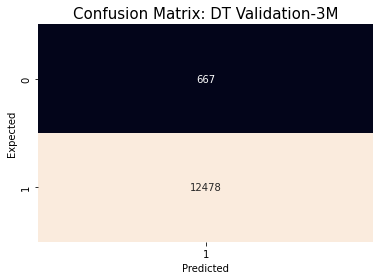

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       667
           1       0.95      1.00      0.97     12478

    accuracy                           0.95     13145
   macro avg       0.47      0.50      0.49     13145
weighted avg       0.90      0.95      0.92     13145



In [118]:
pred_val3M = best_estimator_dt3M.predict(X_val3M)
print('DT-3M Validation Score: %.4f' % metrics.accuracy_score(y_val3M, pred_val3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val3M, columns=pred_val3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: DT Validation-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val3M, pred_val3M))

#### 2-b. 1 year end-point

In [119]:
%%time
gs_dt.fit(X_train1Y, y_train1Y)

CPU times: total: 27.5 s
Wall time: 4min 6s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_leaf': [10, 30, 50, 70, 90, 110, 130, 150,
                                              170, 190, 210, 230, 250, 270, 290,
                                              310, 330, 350, 370, 390, 410, 430,
                                              450, 470, 490]},
             scoring='recall')

In [120]:
gs_dt.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [121]:
best_estimator_dt1Y = gs_dt.best_estimator_

DT-1Y Validation Score: 0.8392
------------------------------------------------------------


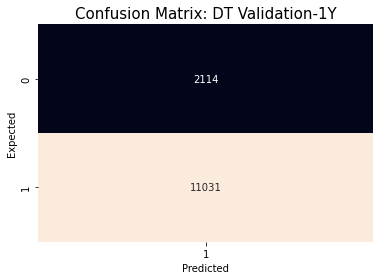

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2114
           1       0.84      1.00      0.91     11031

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.70      0.84      0.77     13145



In [122]:
pred_val1Y = best_estimator_dt1Y.predict(X_val1Y)
print('DT-1Y Validation Score: %.4f' % metrics.accuracy_score(y_val1Y, pred_val1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val1Y, columns=pred_val1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: DT Validation-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val1Y, pred_val1Y))

#### 2-c. 2 years end-point

In [123]:
%%time
gs_dt.fit(X_train2Y, y_train2Y)

CPU times: total: 32 s
Wall time: 4min 27s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_leaf': [10, 30, 50, 70, 90, 110, 130, 150,
                                              170, 190, 210, 230, 250, 270, 290,
                                              310, 330, 350, 370, 390, 410, 430,
                                              450, 470, 490]},
             scoring='recall')

In [124]:
gs_dt.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [125]:
best_estimator_dt2Y = gs_dt.best_estimator_

DT-2Y Validation Score: 0.7262
------------------------------------------------------------


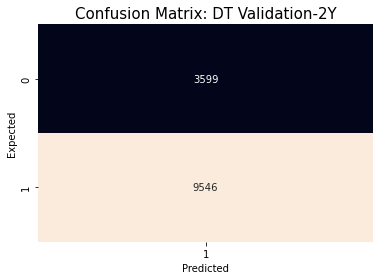

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3599
           1       0.73      1.00      0.84      9546

    accuracy                           0.73     13145
   macro avg       0.36      0.50      0.42     13145
weighted avg       0.53      0.73      0.61     13145



In [126]:
pred_val2Y = best_estimator_dt2Y.predict(X_val2Y)
print('DT-2Y Validation Score: %.4f' % metrics.accuracy_score(y_val2Y, pred_val2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val2Y, columns=pred_val2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: DT Validation-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val2Y, pred_val2Y))

#### 2-d. 5 years end-point

In [127]:
%%time
gs_dt.fit(X_train5Y, y_train5Y)

CPU times: total: 32 s
Wall time: 4min 36s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_leaf': [10, 30, 50, 70, 90, 110, 130, 150,
                                              170, 190, 210, 230, 250, 270, 290,
                                              310, 330, 350, 370, 390, 410, 430,
                                              450, 470, 490]},
             scoring='recall')

In [128]:
gs_dt.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [129]:
best_estimator_dt5Y = gs_dt.best_estimator_

DT-5Y Validation Score: 0.5405
------------------------------------------------------------


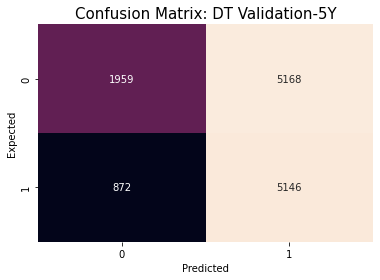

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.27      0.39      7127
           1       0.50      0.86      0.63      6018

    accuracy                           0.54     13145
   macro avg       0.60      0.56      0.51     13145
weighted avg       0.60      0.54      0.50     13145



In [130]:
pred_val5Y = best_estimator_dt5Y.predict(X_val5Y)
print('DT-5Y Validation Score: %.4f' % metrics.accuracy_score(y_val5Y, pred_val5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val5Y, columns=pred_val5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: DT Validation-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val5Y, pred_val5Y))

### 3. Random Forest (RF)

- Random Forest with 10 cross validation
- Using the training data perform hyper-parameter tuning. 
- Use an appropriate metric for scoring (Recall). The best parameter configuration is the one that obtained the maximum Recall in the nested 10-fold cross-validation because one of the main objectives is to increase the classification rate of the minority class (in this case, the non-survival).
- Perform grid search (`GridSearchCV`) where checking for the following parameters.
- Using the best model provide the performance metrics for the validation set.
- Hyperparameters used during the model selection, except for (n_estimators=100, 1000) :

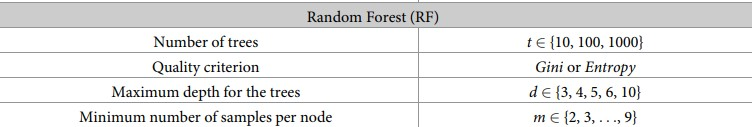

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
# Create parameters dictionary
params = dict(
    n_estimators = [10],
    criterion = ['gini', 'entropy'],
    max_depth = [3,4,5,6,10],
    min_samples_leaf = [i for i in range(2,10,1)]
)

params

{'n_estimators': [10],
 'criterion': ['gini', 'entropy'],
 'max_depth': [3, 4, 5, 6, 10],
 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9]}

In [96]:
rf = RandomForestClassifier()
gs_rf = GridSearchCV(estimator=rf, param_grid=params, scoring='recall', cv=cv, n_jobs=-1)

#### 3-a. 3 months end-point

In [97]:
%%time
gs_rf.fit(X_train3M, y_train3M)

CPU times: total: 5.48 s
Wall time: 27.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10]},
             scoring='recall')

In [98]:
gs_rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [99]:
best_estimator_rf3M = gs_rf.best_estimator_

RF-3M Validation Score: 0.9493
------------------------------------------------------------


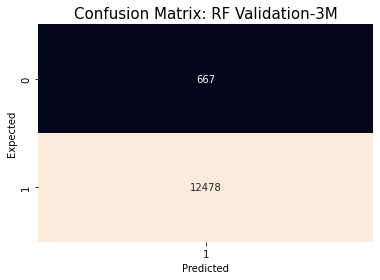

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       667
           1       0.95      1.00      0.97     12478

    accuracy                           0.95     13145
   macro avg       0.47      0.50      0.49     13145
weighted avg       0.90      0.95      0.92     13145



In [100]:
pred_val3M = best_estimator_rf3M.predict(X_val3M)
print('RF-3M Validation Score: %.4f' % metrics.accuracy_score(y_val3M, pred_val3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val3M, columns=pred_val3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: RF Validation-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val3M, pred_val3M))

#### 3-b. 1 year end-point

In [101]:
%%time
gs_rf.fit(X_train1Y, y_train1Y)

CPU times: total: 3.39 s
Wall time: 25 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10]},
             scoring='recall')

In [102]:
gs_rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [103]:
best_estimator_rf1Y = gs_rf.best_estimator_

RF-1Y Validation Score: 0.8392
------------------------------------------------------------


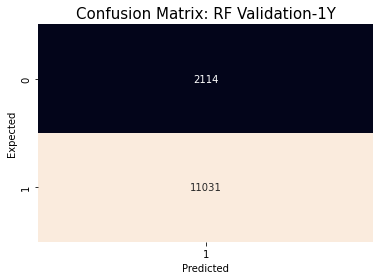

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2114
           1       0.84      1.00      0.91     11031

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.70      0.84      0.77     13145



In [104]:
pred_val1Y = best_estimator_rf1Y.predict(X_val1Y)
print('RF-1Y Validation Score: %.4f' % metrics.accuracy_score(y_val1Y, pred_val1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val1Y, columns=pred_val1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: RF Validation-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val1Y, pred_val1Y))

#### 3-c. 2 years end-point

In [105]:
%%time
gs_rf.fit(X_train2Y, y_train2Y)

CPU times: total: 3.42 s
Wall time: 24.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10]},
             scoring='recall')

In [106]:
gs_rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [107]:
best_estimator_rf2Y = gs_rf.best_estimator_

RF-2Y Validation Score: 0.7264
------------------------------------------------------------


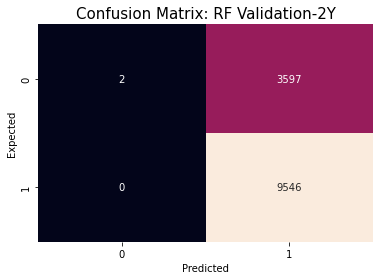

------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3599
           1       0.73      1.00      0.84      9546

    accuracy                           0.73     13145
   macro avg       0.86      0.50      0.42     13145
weighted avg       0.80      0.73      0.61     13145



In [108]:
pred_val2Y = best_estimator_rf2Y.predict(X_val2Y)
print('RF-2Y Validation Score: %.4f' % metrics.accuracy_score(y_val2Y, pred_val2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val2Y, columns=pred_val2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: RF Validation-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val2Y, pred_val2Y))

#### 3-d. 5 years end-point

In [109]:
%%time
gs_rf.fit(X_train5Y, y_train5Y)

CPU times: total: 3.31 s
Wall time: 24.7 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10]},
             scoring='recall')

In [110]:
gs_rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [111]:
best_estimator_rf5Y = gs_rf.best_estimator_

RF-5Y Validation Score: 0.6336
------------------------------------------------------------


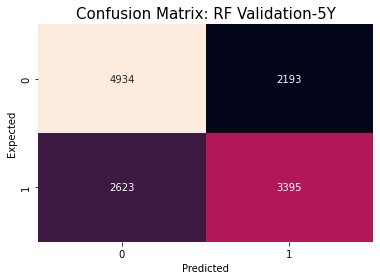

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.69      0.67      7127
           1       0.61      0.56      0.59      6018

    accuracy                           0.63     13145
   macro avg       0.63      0.63      0.63     13145
weighted avg       0.63      0.63      0.63     13145



In [112]:
pred_val5Y = best_estimator_rf5Y.predict(X_val5Y)
print('RF-5Y Validation Score: %.4f' % metrics.accuracy_score(y_val5Y, pred_val5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val5Y, columns=pred_val5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: RF Validation-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val5Y, pred_val5Y))

### 4. Gradient Boosting (GB)

- Gradient Boosting with 10 cross validation
- Using the training data perform hyper-parameter tuning. 
- Use an appropriate metric for scoring (Recall). The best parameter configuration is the one that obtained the maximum Recall in the nested 10-fold cross-validation because one of the main objectives is to increase the classification rate of the minority class (in this case, the non-survival).
- Perform grid search (`GridSearchCV`) where checking for the following parameters.
- Using the best model provide the performance metrics for the validation set.
- Hyperparameters used during the model selection, except for (n_estimators=100, 1000) :

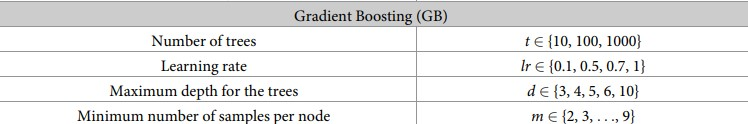

In [113]:
from sklearn.ensemble import GradientBoostingClassifier

In [114]:
# Create parameters dictionary
params = dict(
    n_estimators = [10],
    learning_rate = [0.1, 0.5, 0.7, 1],
    max_depth = [3,4,5,6,10],
    min_samples_leaf = [i for i in range(2,10,1)]
)

params

{'n_estimators': [10],
 'learning_rate': [0.1, 0.5, 0.7, 1],
 'max_depth': [3, 4, 5, 6, 10],
 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9]}

In [115]:
gb = GradientBoostingClassifier()
gs_gb = GridSearchCV(estimator=gb, param_grid=params, scoring='recall', cv=cv, n_jobs=-1)

#### 4-a. 3 months end-point

In [116]:
%%time
gs_gb.fit(X_train3M, y_train3M)

CPU times: total: 10.9 s
Wall time: 5min 38s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.7, 1],
                         'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10]},
             scoring='recall')

In [117]:
gs_gb.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [118]:
best_estimator_gb3M = gs_gb.best_estimator_

GB-3M Validation Score: 0.9493
------------------------------------------------------------


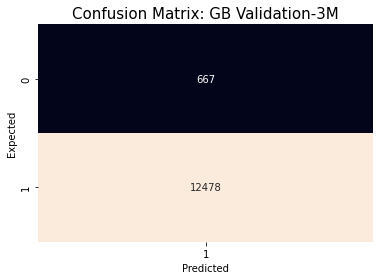

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       667
           1       0.95      1.00      0.97     12478

    accuracy                           0.95     13145
   macro avg       0.47      0.50      0.49     13145
weighted avg       0.90      0.95      0.92     13145



In [119]:
pred_val3M = best_estimator_gb3M.predict(X_val3M)
print('GB-3M Validation Score: %.4f' % metrics.accuracy_score(y_val3M, pred_val3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val3M, columns=pred_val3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: GB Validation-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val3M, pred_val3M))

#### 4-b. 1 year end-point

In [120]:
%%time
gs_gb.fit(X_train1Y, y_train1Y)

CPU times: total: 10.7 s
Wall time: 5min 46s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.7, 1],
                         'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10]},
             scoring='recall')

In [121]:
gs_gb.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [122]:
best_estimator_gb1Y = gs_gb.best_estimator_

GB-1Y Validation Score: 0.8392
------------------------------------------------------------


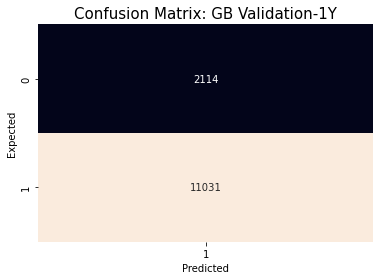

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2114
           1       0.84      1.00      0.91     11031

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.70      0.84      0.77     13145



In [123]:
pred_val1Y = best_estimator_gb1Y.predict(X_val1Y)
print('GB-1Y Validation Score: %.4f' % metrics.accuracy_score(y_val1Y, pred_val1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val1Y, columns=pred_val1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: GB Validation-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val1Y, pred_val1Y))

#### 4-c. 2 years end-point

In [124]:
%%time
gs_gb.fit(X_train2Y, y_train2Y)

CPU times: total: 10.4 s
Wall time: 5min 45s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.7, 1],
                         'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10]},
             scoring='recall')

In [125]:
gs_gb.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [126]:
best_estimator_gb2Y = gs_gb.best_estimator_

GB-2Y Validation Score: 0.7287
------------------------------------------------------------


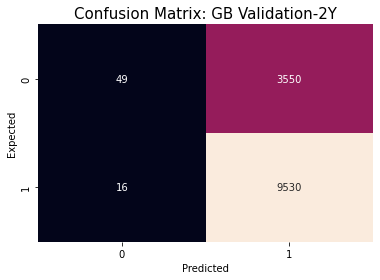

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.01      0.03      3599
           1       0.73      1.00      0.84      9546

    accuracy                           0.73     13145
   macro avg       0.74      0.51      0.43     13145
weighted avg       0.74      0.73      0.62     13145



In [127]:
pred_val2Y = best_estimator_gb2Y.predict(X_val2Y)
print('GB-2Y Validation Score: %.4f' % metrics.accuracy_score(y_val2Y, pred_val2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val2Y, columns=pred_val2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: GB Validation-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val2Y, pred_val2Y))

#### 4-d. 5 years end-point

In [128]:
%%time
gs_gb.fit(X_train5Y, y_train5Y)

CPU times: total: 11.4 s
Wall time: 5min 54s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 0.7, 1],
                         'max_depth': [3, 4, 5, 6, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10]},
             scoring='recall')

In [129]:
gs_gb.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 1,
 'loss': 'deviance',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [130]:
best_estimator_gb5Y = gs_gb.best_estimator_

GB-5Y Validation Score: 0.6741
------------------------------------------------------------


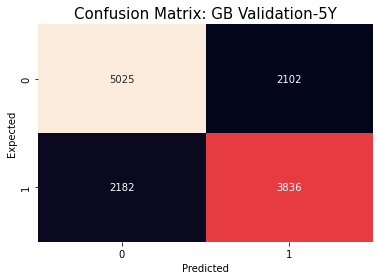

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      7127
           1       0.65      0.64      0.64      6018

    accuracy                           0.67     13145
   macro avg       0.67      0.67      0.67     13145
weighted avg       0.67      0.67      0.67     13145



In [131]:
pred_val5Y = best_estimator_gb5Y.predict(X_val5Y)
print('GB-5Y Validation Score: %.4f' % metrics.accuracy_score(y_val5Y, pred_val5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val5Y, columns=pred_val5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: GB Validation-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val5Y, pred_val5Y))

### 5. K-Nearest Neighbors (KNN) 

- K-Nearest Neighbors with 10 cross validation
- Using the training data perform hyper-parameter tuning. 
- Use an appropriate metric for scoring (Recall). The best parameter configuration is the one that obtained the maximum Recall in the nested 10-fold cross-validation because one of the main objectives is to increase the classification rate of the minority class (in this case, the non-survival).
- Perform grid search (`GridSearchCV`) where checking for the following parameters.
- Using the best model provide the performance metrics for the validation set.
- Hyperparameters used during the model selection:

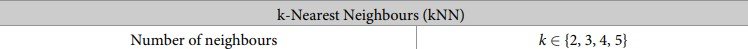

In [140]:
from sklearn.neighbors import KNeighborsClassifier

In [141]:
params = dict(
    n_neighbors = [2,3,4,5]   
)
params

{'n_neighbors': [2, 3, 4, 5]}

In [142]:
knn = KNeighborsClassifier()
gs_knn = GridSearchCV(estimator=knn, param_grid=params, scoring='recall', cv=cv, n_jobs=-1)

#### 5-a. 3 months end-point

In [143]:
%%time
gs_knn.fit(X_train3M, y_train3M)

CPU times: total: 422 ms
Wall time: 27.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5]}, scoring='recall')

In [144]:
gs_knn.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [145]:
best_estimator_knn3M = gs_knn.best_estimator_

KNN-3M Validation Score: 0.9477
------------------------------------------------------------


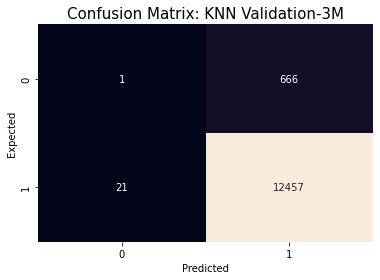

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.05      0.00      0.00       667
           1       0.95      1.00      0.97     12478

    accuracy                           0.95     13145
   macro avg       0.50      0.50      0.49     13145
weighted avg       0.90      0.95      0.92     13145



In [146]:
pred_val3M = best_estimator_knn3M.predict(X_val3M)
print('KNN-3M Validation Score: %.4f' % metrics.accuracy_score(y_val3M, pred_val3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val3M, columns=pred_val3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: KNN Validation-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val3M, pred_val3M))

#### 5-b. 1 year end-point

In [147]:
%%time
gs_knn.fit(X_train1Y, y_train1Y)

CPU times: total: 375 ms
Wall time: 27.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5]}, scoring='recall')

In [148]:
gs_knn.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [149]:
best_estimator_knn1Y = gs_knn.best_estimator_

KNN-1Y Validation Score: 0.8193
------------------------------------------------------------


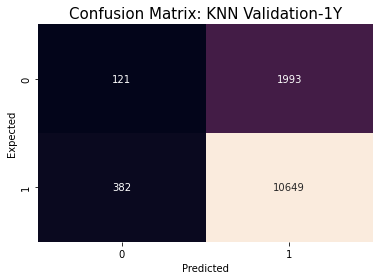

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.24      0.06      0.09      2114
           1       0.84      0.97      0.90     11031

    accuracy                           0.82     13145
   macro avg       0.54      0.51      0.50     13145
weighted avg       0.75      0.82      0.77     13145



In [150]:
pred_val1Y = best_estimator_knn1Y.predict(X_val1Y)
print('KNN-1Y Validation Score: %.4f' % metrics.accuracy_score(y_val1Y, pred_val1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val1Y, columns=pred_val1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: KNN Validation-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val1Y, pred_val1Y))

#### 5-c. 2 years end-point

In [151]:
%%time
gs_knn.fit(X_train2Y, y_train2Y)

CPU times: total: 797 ms
Wall time: 27.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5]}, scoring='recall')

In [152]:
gs_knn.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [153]:
best_estimator_knn2Y = gs_knn.best_estimator_

KNN-2Y Validation Score: 0.6879
------------------------------------------------------------


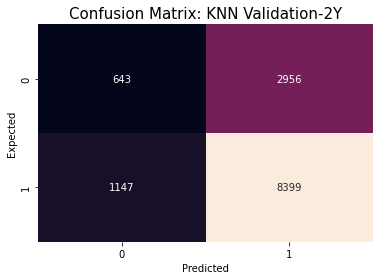

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.36      0.18      0.24      3599
           1       0.74      0.88      0.80      9546

    accuracy                           0.69     13145
   macro avg       0.55      0.53      0.52     13145
weighted avg       0.64      0.69      0.65     13145



In [154]:
pred_val2Y = best_estimator_knn2Y.predict(X_val2Y)
print('KNN-2Y Validation Score: %.4f' % metrics.accuracy_score(y_val2Y, pred_val2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val2Y, columns=pred_val2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: KNN Validation-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val2Y, pred_val2Y))

#### 5-d. 5 years end-point

In [155]:
%%time
gs_knn.fit(X_train5Y, y_train5Y)

CPU times: total: 344 ms
Wall time: 27.1 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5]}, scoring='recall')

In [156]:
gs_knn.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [157]:
best_estimator_knn5Y = gs_knn.best_estimator_

KNN-5Y Validation Score: 0.5637
------------------------------------------------------------


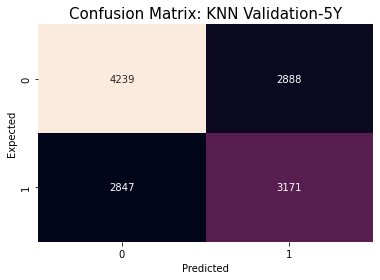

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.59      0.60      7127
           1       0.52      0.53      0.53      6018

    accuracy                           0.56     13145
   macro avg       0.56      0.56      0.56     13145
weighted avg       0.56      0.56      0.56     13145



In [158]:
pred_val5Y = best_estimator_knn5Y.predict(X_val5Y)
print('KNN-5Y Validation Score: %.4f' % metrics.accuracy_score(y_val5Y, pred_val5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val5Y, columns=pred_val5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: KNN Validation-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val5Y, pred_val5Y))

### 6. Support Vector Machines (SVM)

- RBF Kernel SVM Classifier
- Using the training data perform default hyper-parameter
- Using the model provide the performance metrics for the validation set.

In [140]:
from sklearn.svm import SVC

#### 6-a. 3 months end-point

In [141]:
svc3M = SVC(kernel ='rbf')

In [142]:
%%time
svc3M.fit(X_train3M, y_train3M)

CPU times: total: 16.5 s
Wall time: 17.8 s


SVC()

SVC-3M Validation Score: 0.9493
------------------------------------------------------------


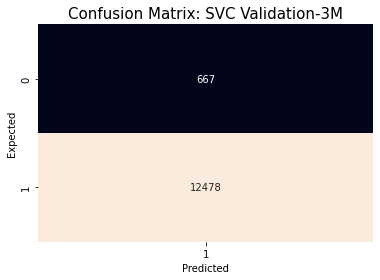

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       667
           1       0.95      1.00      0.97     12478

    accuracy                           0.95     13145
   macro avg       0.47      0.50      0.49     13145
weighted avg       0.90      0.95      0.92     13145



In [143]:
pred_val3M = svc3M.predict(X_val3M)
print('SVC-3M Validation Score: %.4f' % metrics.accuracy_score(y_val3M, pred_val3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val3M, columns=pred_val3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: SVC Validation-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val3M, pred_val3M))

#### 6-b. 1 year end-point

In [144]:
svc1Y = SVC(kernel ='rbf')

In [145]:
%%time
svc1Y.fit(X_train1Y, y_train1Y)

CPU times: total: 1min
Wall time: 1min 11s


SVC()

SVC-1Y Validation Score: 0.8392
------------------------------------------------------------


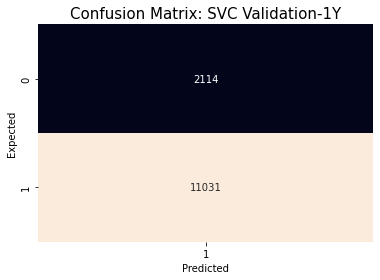

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2114
           1       0.84      1.00      0.91     11031

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.70      0.84      0.77     13145



In [146]:
pred_val1Y = svc1Y.predict(X_val1Y)
print('SVC-1Y Validation Score: %.4f' % metrics.accuracy_score(y_val1Y, pred_val1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val1Y, columns=pred_val1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: SVC Validation-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val1Y, pred_val1Y))

#### 6-c. 2 years end-point

In [147]:
svc2Y = SVC(kernel ='rbf')

In [148]:
%%time
svc2Y.fit(X_train2Y, y_train2Y)

CPU times: total: 2min 21s
Wall time: 2min 40s


SVC()

SVC-2Y Validation Score: 0.7261
------------------------------------------------------------


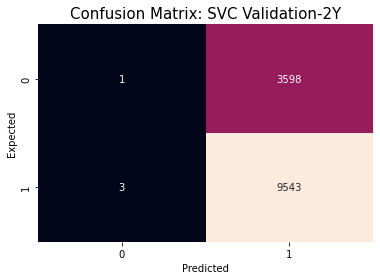

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.25      0.00      0.00      3599
           1       0.73      1.00      0.84      9546

    accuracy                           0.73     13145
   macro avg       0.49      0.50      0.42     13145
weighted avg       0.60      0.73      0.61     13145



In [149]:
pred_val2Y = svc2Y.predict(X_val2Y)
print('SVC-2Y Validation Score: %.4f' % metrics.accuracy_score(y_val2Y, pred_val2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val2Y, columns=pred_val2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: SVC Validation-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val2Y, pred_val2Y))

#### 6-d. 5 years end-point

In [150]:
svc5Y = SVC(kernel ='rbf')

In [151]:
%%time
svc5Y.fit(X_train5Y, y_train5Y)

CPU times: total: 2min 56s
Wall time: 3min 2s


SVC()

SVC-5Y Validation Score: 0.5549
------------------------------------------------------------


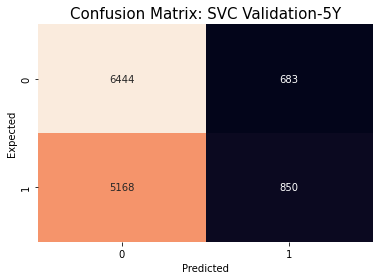

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.90      0.69      7127
           1       0.55      0.14      0.23      6018

    accuracy                           0.55     13145
   macro avg       0.55      0.52      0.46     13145
weighted avg       0.55      0.55      0.48     13145



In [152]:
pred_val5Y = svc5Y.predict(X_val5Y)
print('SVC-5Y Validation Score: %.4f' % metrics.accuracy_score(y_val5Y, pred_val5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_val5Y, columns=pred_val5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: SVC Validation-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_val5Y, pred_val5Y))

--------------------------------------------------------

#### Summary table for validation dataset

In [164]:
tbl = {'End-Point': [ '3M', '1Y', '2Y', '5Y'],
        'LR': [0.9493, 0.8392, 0.7262, 0.6234],
        'DT': [0.9493, 0.8392, 0.7262, 0.5405],
        'RF': [0.9493, 0.8392, 0.7264, 0.6336],
        'GB': [0.9493, 0.8392, 0.7287, 0.6741],
        'KNN': [0.9477, 0.8193, 0.6879, 0.5637],
        'SVM': [0.9493, 0.8392, 0.7261, 0.5549]}

tbl = pd.DataFrame(tbl)
tbl.set_index('End-Point')

,LR,DT,RF,GB,KNN,SVM
End-Point,,,,,,
3M,0.9493,0.9493,0.9493,0.9493,0.9477,0.9493
1Y,0.8392,0.8392,0.8392,0.8392,0.8193,0.8392
2Y,0.7262,0.7262,0.7264,0.7287,0.6879,0.7261
5Y,0.6234,0.5405,0.6336,0.6741,0.5637,0.5549


Among 3M, 1Y, and 2Y end-points, all the models obtain similar results. Focusing on the 5Y end-point, Gradient Boosting (GB) has the best performance in the validation dataset. Overall, the performance of each model does not differ much from each other.

## Results

### 1. Use test dataset to predict and then find the best model

#### a. 3M End-Point

LR-3M Test Score: 0.9510
------------------------------------------------------------


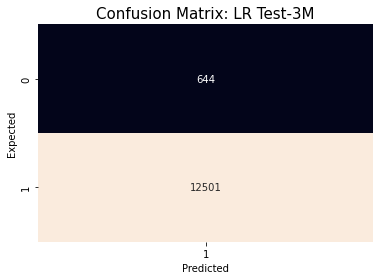

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       644
           1       0.95      1.00      0.97     12501

    accuracy                           0.95     13145
   macro avg       0.48      0.50      0.49     13145
weighted avg       0.90      0.95      0.93     13145



In [109]:
pred_test3M = best_estimator_lr3M.predict(X_test3M)
print('LR-3M Test Score: %.4f' % metrics.accuracy_score(y_test3M, pred_test3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test3M, columns=pred_test3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: LR Test-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test3M, pred_test3M))

DT-3M Test Score: 0.9510
------------------------------------------------------------


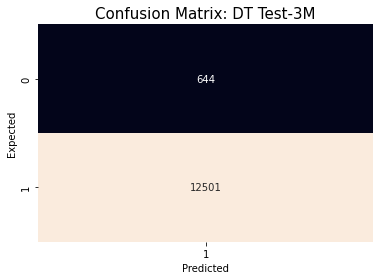

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       644
           1       0.95      1.00      0.97     12501

    accuracy                           0.95     13145
   macro avg       0.48      0.50      0.49     13145
weighted avg       0.90      0.95      0.93     13145



In [131]:
pred_test3M = best_estimator_dt3M.predict(X_test3M)
print('DT-3M Test Score: %.4f' % metrics.accuracy_score(y_test3M, pred_test3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test3M, columns=pred_test3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: DT Test-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test3M, pred_test3M))

RF-3M Test Score: 0.9510
------------------------------------------------------------


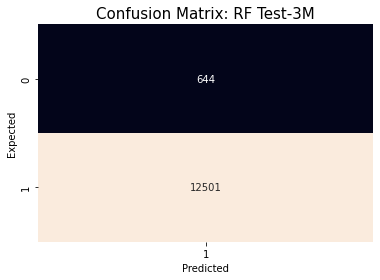

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       644
           1       0.95      1.00      0.97     12501

    accuracy                           0.95     13145
   macro avg       0.48      0.50      0.49     13145
weighted avg       0.90      0.95      0.93     13145



In [132]:
pred_test3M = best_estimator_rf3M.predict(X_test3M)
print('RF-3M Test Score: %.4f' % metrics.accuracy_score(y_test3M, pred_test3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test3M, columns=pred_test3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: RF Test-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test3M, pred_test3M))

GB-3M Test Score: 0.9510
------------------------------------------------------------


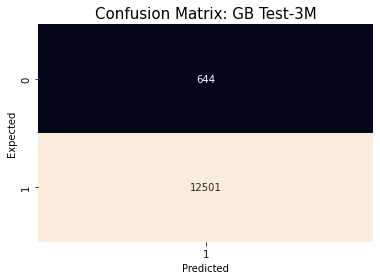

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       644
           1       0.95      1.00      0.97     12501

    accuracy                           0.95     13145
   macro avg       0.48      0.50      0.49     13145
weighted avg       0.90      0.95      0.93     13145



In [133]:
pred_test3M = best_estimator_gb3M.predict(X_test3M)
print('GB-3M Test Score: %.4f' % metrics.accuracy_score(y_test3M, pred_test3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test3M, columns=pred_test3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: GB Test-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test3M, pred_test3M))

KNN-3M Test Score: 0.9495
------------------------------------------------------------


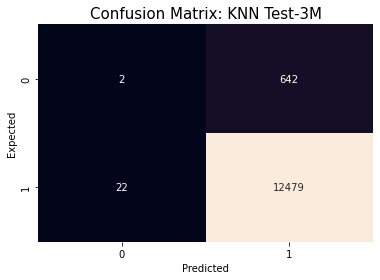

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.08      0.00      0.01       644
           1       0.95      1.00      0.97     12501

    accuracy                           0.95     13145
   macro avg       0.52      0.50      0.49     13145
weighted avg       0.91      0.95      0.93     13145



In [159]:
pred_test3M = best_estimator_knn3M.predict(X_test3M)
print('KNN-3M Test Score: %.4f' % metrics.accuracy_score(y_test3M, pred_test3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test3M, columns=pred_test3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: KNN Test-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test3M, pred_test3M))

SVM-3M Test Score: 0.9510
------------------------------------------------------------


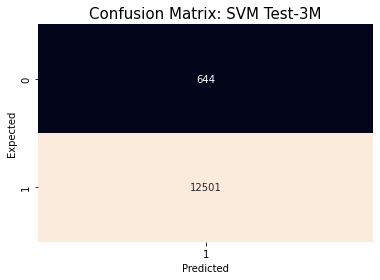

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       644
           1       0.95      1.00      0.97     12501

    accuracy                           0.95     13145
   macro avg       0.48      0.50      0.49     13145
weighted avg       0.90      0.95      0.93     13145



In [153]:
pred_test3M = svc3M.predict(X_test3M)
print('SVM-3M Test Score: %.4f' % metrics.accuracy_score(y_test3M, pred_test3M))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test3M, columns=pred_test3M.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: SVM Test-3M", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test3M, pred_test3M))

#### b. 1Y End-Point

LR-1Y Test Score: 0.8399
------------------------------------------------------------


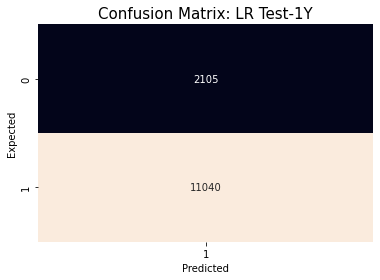

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2105
           1       0.84      1.00      0.91     11040

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.71      0.84      0.77     13145



In [134]:
pred_test1Y = best_estimator_lr1Y.predict(X_test1Y)
print('LR-1Y Test Score: %.4f' % metrics.accuracy_score(y_test1Y, pred_test1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test1Y, columns=pred_test1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: LR Test-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test1Y, pred_test1Y))

DT-1Y Test Score: 0.8399
------------------------------------------------------------


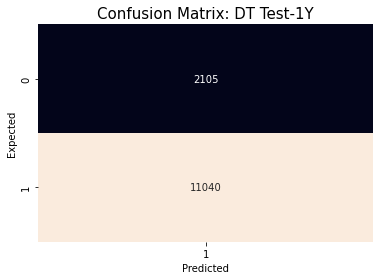

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2105
           1       0.84      1.00      0.91     11040

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.71      0.84      0.77     13145



In [135]:
pred_test1Y = best_estimator_dt1Y.predict(X_test1Y)
print('DT-1Y Test Score: %.4f' % metrics.accuracy_score(y_test1Y, pred_test1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test1Y, columns=pred_test1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: DT Test-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test1Y, pred_test1Y))

RF-1Y Test Score: 0.8399
------------------------------------------------------------


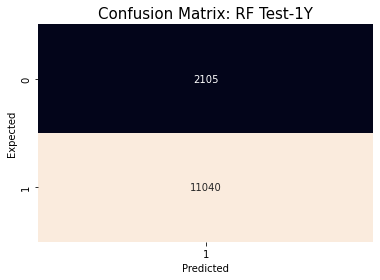

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2105
           1       0.84      1.00      0.91     11040

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.71      0.84      0.77     13145



In [134]:
pred_test1Y = best_estimator_rf1Y.predict(X_test1Y)
print('RF-1Y Test Score: %.4f' % metrics.accuracy_score(y_test1Y, pred_test1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test1Y, columns=pred_test1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: RF Test-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test1Y, pred_test1Y))

GB-1Y Test Score: 0.8399
------------------------------------------------------------


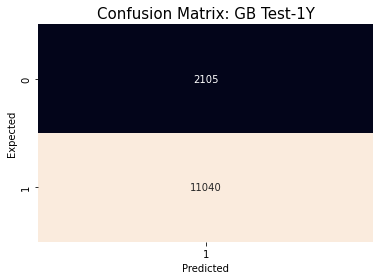

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2105
           1       0.84      1.00      0.91     11040

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.71      0.84      0.77     13145



In [135]:
pred_test1Y = best_estimator_gb1Y.predict(X_test1Y)
print('GB-1Y Test Score: %.4f' % metrics.accuracy_score(y_test1Y, pred_test1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test1Y, columns=pred_test1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: GB Test-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test1Y, pred_test1Y))

KNN-1Y Test Score: 0.8188
------------------------------------------------------------


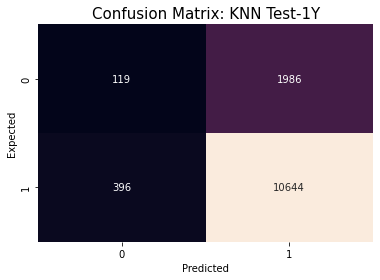

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.23      0.06      0.09      2105
           1       0.84      0.96      0.90     11040

    accuracy                           0.82     13145
   macro avg       0.54      0.51      0.50     13145
weighted avg       0.74      0.82      0.77     13145



In [160]:
pred_test1Y = best_estimator_knn1Y.predict(X_test1Y)
print('KNN-1Y Test Score: %.4f' % metrics.accuracy_score(y_test1Y, pred_test1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test1Y, columns=pred_test1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: KNN Test-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test1Y, pred_test1Y))

SVM-1Y Test Score: 0.8399
------------------------------------------------------------


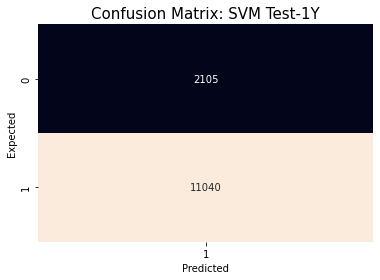

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2105
           1       0.84      1.00      0.91     11040

    accuracy                           0.84     13145
   macro avg       0.42      0.50      0.46     13145
weighted avg       0.71      0.84      0.77     13145



In [154]:
pred_test1Y = svc1Y.predict(X_test1Y)
print('SVM-1Y Test Score: %.4f' % metrics.accuracy_score(y_test1Y, pred_test1Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test1Y, columns=pred_test1Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: SVM Test-1Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test1Y, pred_test1Y))

#### c. 2Y End-Point

LR-2Y Test Score: 0.7238
------------------------------------------------------------


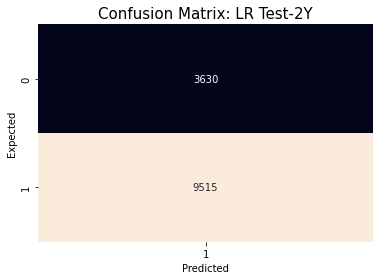

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3630
           1       0.72      1.00      0.84      9515

    accuracy                           0.72     13145
   macro avg       0.36      0.50      0.42     13145
weighted avg       0.52      0.72      0.61     13145



In [136]:
pred_test2Y = best_estimator_lr2Y.predict(X_test2Y)
print('LR-2Y Test Score: %.4f' % metrics.accuracy_score(y_test2Y, pred_test2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test2Y, columns=pred_test2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: LR Test-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test2Y, pred_test2Y))

DT-2Y Test Score: 0.7238
------------------------------------------------------------


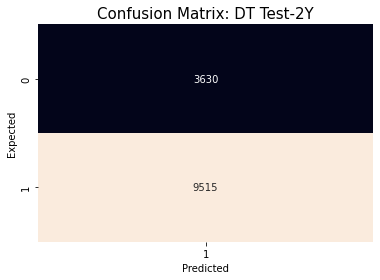

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3630
           1       0.72      1.00      0.84      9515

    accuracy                           0.72     13145
   macro avg       0.36      0.50      0.42     13145
weighted avg       0.52      0.72      0.61     13145



In [137]:
pred_test2Y = best_estimator_dt2Y.predict(X_test2Y)
print('DT-2Y Test Score: %.4f' % metrics.accuracy_score(y_test2Y, pred_test2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test2Y, columns=pred_test2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: DT Test-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test2Y, pred_test2Y))

RF-2Y Test Score: 0.7240
------------------------------------------------------------


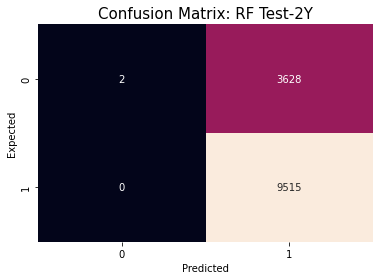

------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3630
           1       0.72      1.00      0.84      9515

    accuracy                           0.72     13145
   macro avg       0.86      0.50      0.42     13145
weighted avg       0.80      0.72      0.61     13145



In [136]:
pred_test2Y = best_estimator_rf2Y.predict(X_test2Y)
print('RF-2Y Test Score: %.4f' % metrics.accuracy_score(y_test2Y, pred_test2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test2Y, columns=pred_test2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: RF Test-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test2Y, pred_test2Y))

GB-2Y Test Score: 0.7254
------------------------------------------------------------


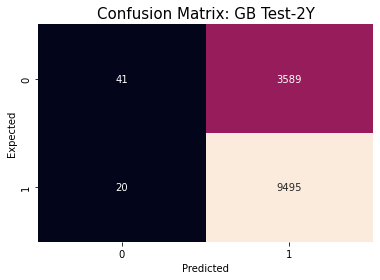

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.01      0.02      3630
           1       0.73      1.00      0.84      9515

    accuracy                           0.73     13145
   macro avg       0.70      0.50      0.43     13145
weighted avg       0.71      0.73      0.61     13145



In [137]:
pred_test2Y = best_estimator_gb2Y.predict(X_test2Y)
print('GB-2Y Test Score: %.4f' % metrics.accuracy_score(y_test2Y, pred_test2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test2Y, columns=pred_test2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: GB Test-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test2Y, pred_test2Y))

KNN-2Y Test Score: 0.6877
------------------------------------------------------------


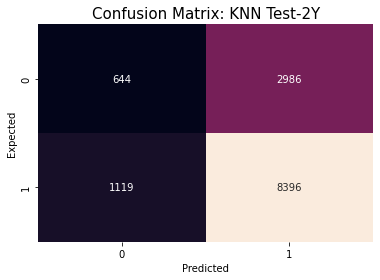

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.37      0.18      0.24      3630
           1       0.74      0.88      0.80      9515

    accuracy                           0.69     13145
   macro avg       0.55      0.53      0.52     13145
weighted avg       0.63      0.69      0.65     13145



In [161]:
pred_test2Y = best_estimator_knn2Y.predict(X_test2Y)
print('KNN-2Y Test Score: %.4f' % metrics.accuracy_score(y_test2Y, pred_test2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test2Y, columns=pred_test2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: KNN Test-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test2Y, pred_test2Y))

SVM-2Y Test Score: 0.7239
------------------------------------------------------------


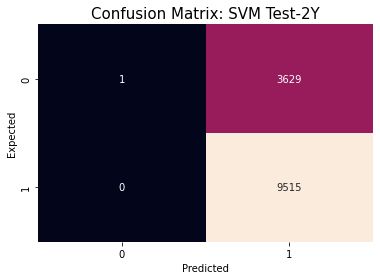

------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3630
           1       0.72      1.00      0.84      9515

    accuracy                           0.72     13145
   macro avg       0.86      0.50      0.42     13145
weighted avg       0.80      0.72      0.61     13145



In [155]:
pred_test2Y = svc2Y.predict(X_test2Y)
print('SVM-2Y Test Score: %.4f' % metrics.accuracy_score(y_test2Y, pred_test2Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test2Y, columns=pred_test2Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: SVM Test-2Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test2Y, pred_test2Y))

#### d. 5Y End-Point

LR-5Y Test Score: 0.6225
------------------------------------------------------------


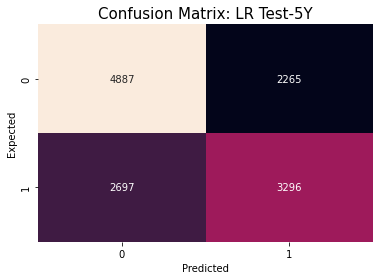

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.68      0.66      7152
           1       0.59      0.55      0.57      5993

    accuracy                           0.62     13145
   macro avg       0.62      0.62      0.62     13145
weighted avg       0.62      0.62      0.62     13145



In [138]:
pred_test5Y = best_estimator_lr5Y.predict(X_test5Y)
print('LR-5Y Test Score: %.4f' % metrics.accuracy_score(y_test5Y, pred_test5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test5Y, columns=pred_test5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: LR Test-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test5Y, pred_test5Y))

DT-5Y Test Score: 0.5368
------------------------------------------------------------


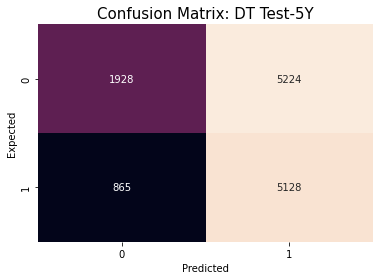

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.27      0.39      7152
           1       0.50      0.86      0.63      5993

    accuracy                           0.54     13145
   macro avg       0.59      0.56      0.51     13145
weighted avg       0.60      0.54      0.50     13145



In [139]:
pred_test5Y = best_estimator_dt5Y.predict(X_test5Y)
print('DT-5Y Test Score: %.4f' % metrics.accuracy_score(y_test5Y, pred_test5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test5Y, columns=pred_test5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: DT Test-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test5Y, pred_test5Y))

RF-5Y Test Score: 0.6361
------------------------------------------------------------


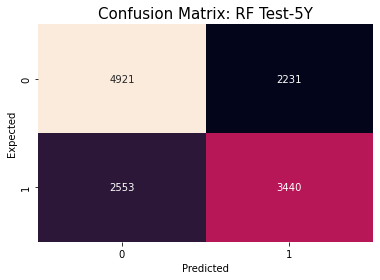

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      7152
           1       0.61      0.57      0.59      5993

    accuracy                           0.64     13145
   macro avg       0.63      0.63      0.63     13145
weighted avg       0.63      0.64      0.64     13145



In [138]:
pred_test5Y = best_estimator_rf5Y.predict(X_test5Y)
print('RF-5Y Test Score: %.4f' % metrics.accuracy_score(y_test5Y, pred_test5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test5Y, columns=pred_test5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: RF Test-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test5Y, pred_test5Y))

GB-5Y Test Score: 0.6780
------------------------------------------------------------


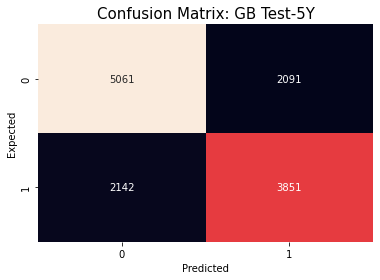

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      7152
           1       0.65      0.64      0.65      5993

    accuracy                           0.68     13145
   macro avg       0.68      0.68      0.68     13145
weighted avg       0.68      0.68      0.68     13145



In [139]:
pred_test5Y = best_estimator_gb5Y.predict(X_test5Y)
print('GB-5Y Test Score: %.4f' % metrics.accuracy_score(y_test5Y, pred_test5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test5Y, columns=pred_test5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: GB Test-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test5Y, pred_test5Y))

KNN-5Y Test Score: 0.5726
------------------------------------------------------------


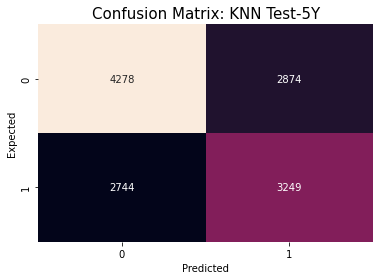

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      7152
           1       0.53      0.54      0.54      5993

    accuracy                           0.57     13145
   macro avg       0.57      0.57      0.57     13145
weighted avg       0.57      0.57      0.57     13145



In [162]:
pred_test5Y = best_estimator_knn5Y.predict(X_test5Y)
print('KNN-5Y Test Score: %.4f' % metrics.accuracy_score(y_test5Y, pred_test5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test5Y, columns=pred_test5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: KNN Test-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test5Y, pred_test5Y))

SVM-5Y Test Score: 0.5525
------------------------------------------------------------


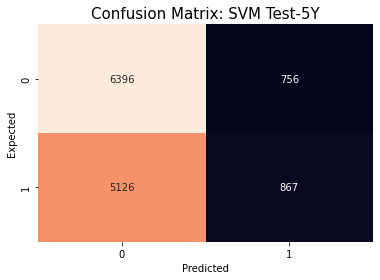

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      0.89      0.69      7152
           1       0.53      0.14      0.23      5993

    accuracy                           0.55     13145
   macro avg       0.54      0.52      0.46     13145
weighted avg       0.55      0.55      0.48     13145



In [156]:
pred_test5Y = svc5Y.predict(X_test5Y)
print('SVM-5Y Test Score: %.4f' % metrics.accuracy_score(y_test5Y, pred_test5Y))
print('-'*60)

confusion_matrix = pd.crosstab(index=y_test5Y, columns=pred_test5Y.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix: SVM Test-5Y", fontsize = 15)
plt.show()
print('-'*60)

print(metrics.classification_report(y_test5Y, pred_test5Y))

--------------------------------------------------------

#### Summary table for test dataset

In [165]:
tbl = {'End-Point': [ '3M', '1Y', '2Y', '5Y'],
        'LR': [0.9510, 0.8399, 0.7238, 0.6225],
        'DT': [0.9510, 0.8399, 0.7238, 0.5368],
        'RF': [0.9510, 0.8399, 0.7240, 0.6361],
        'GB': [0.9510, 0.8399, 0.7254, 0.6780],
        'KNN': [0.9495, 0.8188, 0.6877, 0.5726],
        'SVM': [0.9510, 0.8399, 0.7239, 0.5525]}

tbl = pd.DataFrame(tbl)
tbl.set_index('End-Point')

,LR,DT,RF,GB,KNN,SVM
End-Point,,,,,,
3M,0.9510,0.9510,0.9510,0.9510,0.9495,0.9510
1Y,0.8399,0.8399,0.8399,0.8399,0.8188,0.8399
2Y,0.7238,0.7238,0.7240,0.7254,0.6877,0.7239
5Y,0.6225,0.5368,0.6361,0.6780,0.5726,0.5525


Among 3M, 1Y, and 2Y end-points, all the models obtain similar results, only KNN has a little worse result. Focusing on the 5Y end-point, Gradient Boosting (GB) has the best performance in the test dataset. Overall, each model performs similarly to the validation dataset at different end-points.

### 2. Create a chart showing the feature importances based on the best model obtained

Gradient Boosting (GB) in 5Y end-point is the best model, so we use this model to create the feature importances.

In [240]:
tbl = {'Column_Name': X.columns,
        'Feature_Importances': best_estimator_gb5Y.feature_importances_}

tbl = pd.DataFrame(tbl)
tbl = tbl.sort_values('Feature_Importances', ascending = False).head(15)
tbl

,Column_Name,Feature_Importances
6,CREAT_DON,0.279931
0,AGE,0.120027
39,CDC_RISK_HIV_DON_1,0.099220
2,DAYSWAIT_CHRON,0.090612
3,MELD_PELD_LAB_SCORE,0.087087
5,BMI_DON_CALC,0.058654
4,AGE_DON,0.056310
1,BMI_CALC,0.027839
58,HIST_DRUG_DON_1,0.023896
54,NON_HRT_DON_1,0.022767


<BarContainer object of 10 artists>

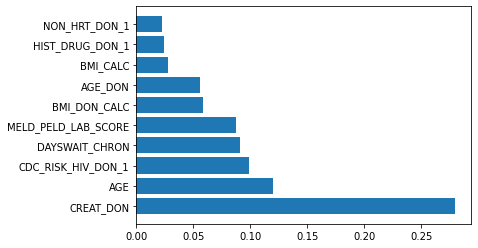

In [239]:
plt.barh(tbl['Column_Name'], tbl['Feature_Importances'], align='center')

## Conclusion

In this project, a deep analysis of the UNOS database regarding liver transplant is presented. The best results are obtained by the Gradient Boosting (GB) method, especially in 5 years end-point, and its prediction accuracy is 0.9510 at 3M, 0.8399 at 1Y, 0.7254 at 2Y, and 0.6780 at 5Y. However, the performance of each model is similar among 3M, 1Y, and 2Y end-points, and one of the reasons behind this is the unbalanced class in each end-point, although I have used Recall in the scoring of the confusion matrix.

I also analyze the best model obtained by the Gradient Boosting (GB) , specifically the importance of each variable for the prediction of graft-survival after transplantation (5-year end-point dataset) is studied in detail. Although the vast majority of important variables belongs to the recipient, there are some variables of the donor with a great impact on the model, such as the index of deceased donor terminal lab creatinine `CREAT_DON` or the donor has risk factors for blood-borme disease transmission `CDC_RISK_HIV_DON_1`. The other variables that contribute most to the models are the age of recipient and donor `AGE` `AGE_DON`, the number of days in the wait list `DAYSWAIT_CHRON`(recipient), the MELD `MELD_PELD_LAB_SCORE`(recipient), among others.

If I had more time, I think I would try to filter variables, improve the handling of missing values, and try more hyperparameters when building models.

